<a href="https://colab.research.google.com/github/vilcagamarracf/Inv_arroz_METRIC/blob/main/files/Inv_Arroz_METRIC_Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruebas (Google Colab)

#### Inicio

##### Credenciales

In [1]:
# # Ingresa tus credenciales de Google Earth Engine para comenzar
# import ee
# ee.Authenticate()

# # Inicio
# ee.Initialize()

# # Mensaje de login
# print('\nYa estás logeado.')
# print('GEE Version:', ee.__version__)

In [2]:
#@markdown *Credenciales Google Earth Engine: Forma rápida*
import os 
credential = '{"refresh_token":"1//09lhqedCNpNDsCgYIARAAGAkSNwF-L9IraEP8FyJma46WSiEHhOMsZqSoTPJsi3Lar0C4nZUwj2QCZ_i66-McVzy4NmMalQL17KM"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)
import ee
ee.Initialize()
print('Ya estás logeado.')
print('GEE Version:',ee.__version__)

Ya estás logeado.
GEE Version: 0.1.293


##### geemap

In [3]:
# Instalar geemap
%%capture
!pip install -U geemap # Nota: Con la actualización de ipyleaflet v0.15.0 se produjo un conflicto con geemap
# !pip install geemap==0.10.1

Documentación `geemap`
- [geemap - key features](https://geemap.org/notebooks/00_geemap_key_features/)

In [4]:
import geemap
# import geemap.eefolium as geemap
Map = geemap.Map(basemap='HYBRID', center=(-9.125, -74.396), zoom=5) # basemap='HYBRID', 'OpenStreetMap.Mapnik' 
Map

Map(center=[-9.125, -74.396], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

# Visualizaciones

##### Funciones

In [ ]:
# Mejorar visibilidad de tablas en Colab
%load_ext google.colab.data_table

# Para volver al estado original de las tablas
# %unload_ext google.colab.data_table

In [ ]:
# Funciones usadas en Inv-Arroz-METRIC
import pandas as pd
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates # Modificar fechas por formato
date_format = mpl_dates.DateFormatter('%Y-%m')

In [ ]:
# @markdown Función `generar_reporte(icol)`

def generar_reporte(icol):
  """Generar reportes para ee.ImageCollection 's
  
  A partir de un ee.ImageCollection devolver una tabla 
  con información de ID, Fechas (Año, Mes, Día, Día Juliano) y 
  propiedades como Ángulo Zenital y Porcentaje de Nubosidad.

  Argumentos:
  - icol : ee.ImageCollection
  Retorna:
  - pandas.Dataframe
  """
  ## Generando campos para la tabla
  ID_snippet_name = icol.getInfo()['id']

  # Lista con fechas (en milisegundos)
  lista_fechas = icol.aggregate_array('system:time_start').getInfo() # Fechas
  # Lista con ID's
  imgCol_ids = [f'{ID_snippet_name}/{i}' for i in icol.aggregate_array("system:index").getInfo()] # ID

  # Armando dataframe
  df = pd.DataFrame(lista_fechas, columns = ['millis'])

  df["ID GEE"] = imgCol_ids
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Fecha Precisa'] = pd.DatetimeIndex(df['Timestamp']) # Con hora
  df['Fecha Corta'] = pd.DatetimeIndex(df['Timestamp']).date
  df['Año'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Mes'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Día'] = pd.DatetimeIndex(df['Timestamp']).day
  # df['Hora'] = pd.DatetimeIndex(df['Timestamp']).hour
  df['Día Juliano'] = pd.DatetimeIndex(df['Timestamp']).dayofyear

  # Agregando propiedades
  if ID_snippet_name == 'LANDSAT/LC08/C01/T1_SR':
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('SOLAR_ZENITH_ANGLE').getInfo()

  if ID_snippet_name == 'LANDSAT/LC08/C01/T1':
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['CLOUD_COVER'] = df['CLOUD_COVER'].round(decimals=3)
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()

  elif ID_snippet_name in ['LANDSAT/LT05/C02/T1_L2','LANDSAT/LC08/C02/T1_L2','LANDSAT/LE07/C02/T1_L2']:
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()
    df['ZENITH ANGLE'] = 90. - df['SUN_ELEVATION']
    df['ZENITH ANGLE'] = df['ZENITH ANGLE'].round(decimals=7)
    df = df.drop(columns=['SUN_ELEVATION'])

  elif ID_snippet_name == 'COPERNICUS/S2_SR':
    df['MEAN_SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUDY_PIXEL_PERCENTAGE'] = icol.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  
  df = df.drop(columns=['millis', 'Timestamp'])
  # df.to_csv('datos_2020_L8_SR.csv')
  
  return df

In [ ]:
# @markdown Función `ver_imgs_mensual(mes, df, roi)`
def ver_imgs_mensual(mes, df, roi):
  """Visualizar imágenes a partir del reporte generado con la función generar_reporte
  
  Argumentos:
  - mes : lista de valores [1,2,3] del 1 al 12 que representen los meses
  - df : pandas.DataFrame con columna 'ID GEE' de ID's 
  - roi : ee.geometry o ee.FeatureCollection 
  Retorna:
  - ee.Image

  Usarse con interact
  """
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imagenes = df[df['Mes'] == mes]['ID GEE'].tolist()
  snippet_name = lista_imagenes[0]

  # Parametros de visualización RGB
  bands = ['B4', 'B3', 'B2']
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}# 'gamma':1.4
  
  # Visualización
  # import geemap.eefolium as geemap
  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)

  if 'COPERNICUS/S2_SR' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)                 
      # image = maskS2clouds(ee.Image(i)).multiply(0.0001)               
      Map.addLayer(image, vis_rgb, f'Imagen {i}')

  elif 'LANDSAT/LC08/C01/T1_SR' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif 'LANDSAT/LC08/C01/T1' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i)
      vis_rgb = {'min': 0.0, 'max': 30000, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif 'LANDSAT/LC08/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B4', 'SR_B3', 'SR_B2']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands} 
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
    
  elif 'LANDSAT/LE07/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B3', 'SR_B2', 'SR_B1']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif 'LANDSAT/LT05/C02/T1_L2' in snippet_name:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B3', 'SR_B2', 'SR_B1']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
  
  empty = ee.Image().paint(roi, 3,5) # https://github.com/google/earthengine-api/blob/6445cae4c371a8244f70ae08c01a6da05dbc4c7d/python/examples/py/FeatureCollection/from_polygons.py
  Map.addLayer(empty, {}, 'ROI')
  return Map

In [ ]:
# @markdown Función `maskS2clouds(image)` para enmascarar nubes en imágenes Sentinel-2

## Operadores de bit a bit
# Operador bit a bit desplazamiento a la izquierda <<
# Little indian (los bits se cuentan de izq a derecha) y Big indian (los bits se cuentan de derecha a izq)
def maskS2clouds(image):
  qa = image.select('QA60')
  opaque_cloud = 1 << 10
  cirrus_cloud = 1 << 11
  mask = (
      qa.bitwiseAnd(opaque_cloud).eq(0)
      .And(qa.bitwiseAnd(cirrus_cloud).eq(0))
  )
  clean_image = (
      image.updateMask(mask)
      .divide(10000)
      .copyProperties(image, ["system:time_start"])
  )
  return clean_image

### Distrito de Chongoyape

Assets personales con datos vectoriales provistos por el Instituto Geográfico Nacional (IGN) de manera [pública](https://www.idep.gob.pe/#visor):
- Departamentos: `'users/CesarVilca/departamentos'`
- Provincias: `'users/CesarVilca/provincias'`
- Distritos: `'users/CesarVilca/distritos'`

In [ ]:
# Ejemplo de filtrado

# Assets
asset_departamentos = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_provincias = ee.FeatureCollection('users/CesarVilca/provincias')
asset_distritos = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
lambayeque = asset_departamentos.filterMetadata('DEPARTAMEN','equals','LAMBAYEQUE')
chiclayo = asset_provincias.filterMetadata('PROVINCIA','equals','CHICLAYO')
chongoyape = asset_distritos.filterMetadata('DISTRITO','equals','CHONGOYAPE')

# Punto
chongoyape_punto = ee.Geometry.Point([-79.389, -6.639])
chongoyape_bound = chongoyape.geometry().bounds() # CAJA

empty = ee.Image().paint(chongoyape, 3,5) # chongoyape solo bordes

# Zona de evaluación
parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")
# parcelas_chongoyape.geometry().centroid().coordinates().getInfo()

In [ ]:
# @markdown Visualización con `geemap`: Distrito de Chongoyape

# Visualización
LambayequeDraw = lambayeque.draw(color = "D8EED0", strokeWidth = 1, pointRadius = 2) 
ChiclayoDraw = chiclayo.draw(color = "00FF00", strokeWidth = 1, pointRadius = 2) 
ChongoyapeDraw = chongoyape.draw(color = "00FFFF", strokeWidth = 1, pointRadius = 2) 
parcelasDraw = parcelas_chongoyape.draw(color = "0000FF", strokeWidth = 1, pointRadius = 2) 

Map = geemap.Map(basemap='HYBRID', layer_ctrl=True) # OpenStreetMap.Mapnik
Map.centerObject(parcelas_chongoyape, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(LambayequeDraw, {}, name = 'Lambayeque')
Map.addLayer(ChiclayoDraw, {}, name = 'Chiclayo')
Map.addLayer(chongoyape_bound, {}, name = 'chongoyape_bound')
Map.addLayer(ChongoyapeDraw, {}, name = 'Chongoyape')
Map.addLayer(parcelasDraw, {}, name = 'Parcelas Chongoyape')

Map

Map(center=[-6.612570768066261, -79.39809118558777], controls=(WidgetControl(options=['position', 'transparent…

### Landsat

#### USGS Landsat 8 Surface Reflectance Tier 1 [deprecated] - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)

In [ ]:
# Filtrado Landsat 8
snippet_name = "LANDSAT/LC08/C01/T1_SR"
path = 10
row = 65
year = 2021
roi = chongoyape_punto

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .filterBounds(roi)
)

reporteL8_C1 = generar_reporte(icol_sr)
reporteL8_C1

ID GEE  ... SOLAR_ZENITH_ANGLE
0   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210102  ...          31.894131
1   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210203  ...          31.967308
2   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210307  ...          30.574303
3   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210323  ...          30.729298
4   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210408  ...          31.944176
5   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210424  ...          34.098743
6   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210510  ...          36.695053
7   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210526  ...          39.111782
8   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210611  ...          40.849697
9   LANDSAT/LC08/C01/T1_SR/LC08_010065_20210627  ...          41.507404
10  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210713  ...          40.875145
11  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210729  ...          38.937775
12  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210814  ...          35.903923
13  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210830  ...          32.179695
14  LANDSAT/LC08/C01/T1_SR/LC08_010065_20210915  ...          28.408939
15  LANDSAT/LC08/C01/T1_SR/LC08_010065_20211001  ...          25.412758
16  LANDSAT/LC08/C01/T1_SR/LC08_010065_20211017  ...          24.016846

[17 rows x 9 columns]

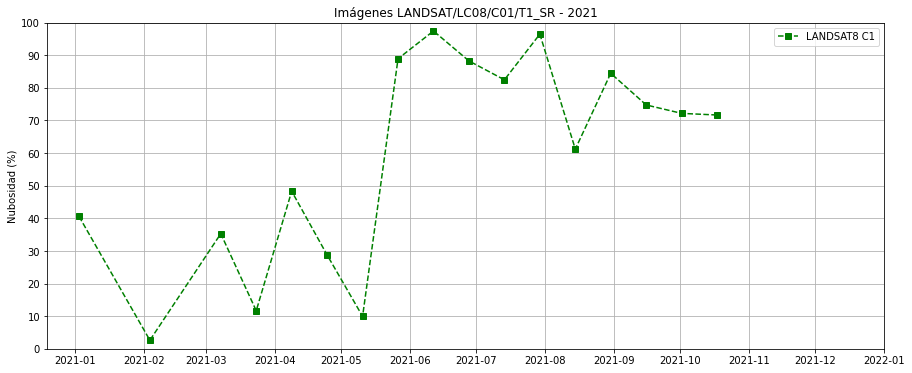

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'gs--', label='LANDSAT8 C1')
plt.title(f'Imágenes {snippet_name} - {year}')
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)

fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

La última imagen data del 17 de Octubre, a partir de esa fecha ya no registra más imágenes en la colección para la zona de evaluación. 

In [ ]:
mes = reporteL8_C1['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL8_C1), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output())…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: No hay imágenes


#### USGS Landsat 8 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2)

In [ ]:
snippet_name = "LANDSAT/LC08/C02/T1_L2"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_C2 = generar_reporte(icol_sr)
reporteL8_C2

ID GEE  ... ZENITH ANGLE
0   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210102  ...    31.894129
1   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210203  ...    31.967307
2   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210307  ...    30.574302
3   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210323  ...    30.729299
4   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210408  ...    31.944175
5   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210424  ...    34.098745
6   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210510  ...    36.695052
7   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210526  ...    39.111781
8   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210611  ...    40.849695
9   LANDSAT/LC08/C02/T1_L2/LC08_010065_20210627  ...    41.507404
10  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210713  ...    40.875147
11  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210729  ...    38.937776
12  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210814  ...    35.903923
13  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210830  ...    32.179696
14  LANDSAT/LC08/C02/T1_L2/LC08_010065_20210915  ...    28.408939
15  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211001  ...    25.412761
16  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211017  ...    24.016849
17  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211102  ...    24.514764
18  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211118  ...    26.406123
19  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211204  ...    28.768697
20  LANDSAT/LC08/C02/T1_L2/LC08_010065_20211220  ...    30.803453

[21 rows x 9 columns]

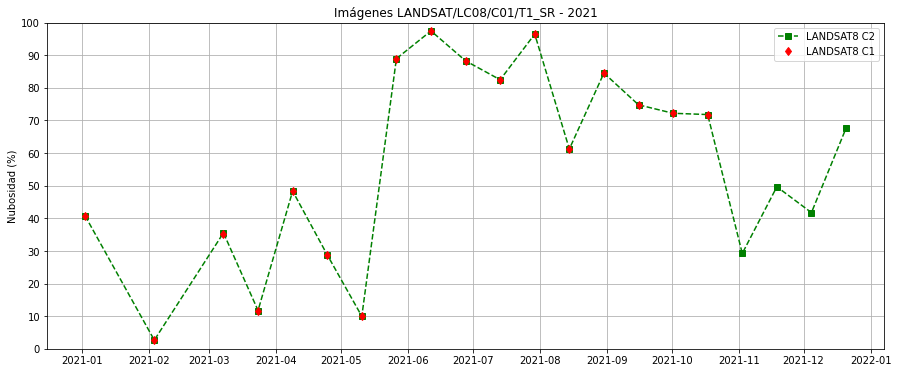

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs--', label='LANDSAT8 C2') 
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT8 C1')

plt.title(f'Imágenes {snippet_name} - {year}')
# Eje Y
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)
# Eje X
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# Linea de filtrado (opcional)
# plt.axhline(10, color = 'b', linewidth = '1') # Resaltar el 0

plt.grid(), plt.legend();

In [ ]:
mes = reporteL8_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL8_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1), O…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


#### USGS Landsat 8 Collection 1 Tier 1 Raw Scenes - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1)

In [ ]:
snippet_name = "LANDSAT/LC08/C01/T1"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_RAW = generar_reporte(icol_sr)
reporteL8_RAW

ID GEE  ... SUN_ELEVATION
0   LANDSAT/LC08/C01/T1/LC08_010065_20210102  ...     58.105869
1   LANDSAT/LC08/C01/T1/LC08_010065_20210203  ...     58.032692
2   LANDSAT/LC08/C01/T1/LC08_010065_20210307  ...     59.425697
3   LANDSAT/LC08/C01/T1/LC08_010065_20210323  ...     59.270702
4   LANDSAT/LC08/C01/T1/LC08_010065_20210408  ...     58.055824
5   LANDSAT/LC08/C01/T1/LC08_010065_20210424  ...     55.901257
6   LANDSAT/LC08/C01/T1/LC08_010065_20210510  ...     53.304947
7   LANDSAT/LC08/C01/T1/LC08_010065_20210526  ...     50.888218
8   LANDSAT/LC08/C01/T1/LC08_010065_20210611  ...     49.150303
9   LANDSAT/LC08/C01/T1/LC08_010065_20210627  ...     48.492596
10  LANDSAT/LC08/C01/T1/LC08_010065_20210713  ...     49.124855
11  LANDSAT/LC08/C01/T1/LC08_010065_20210729  ...     51.062225
12  LANDSAT/LC08/C01/T1/LC08_010065_20210814  ...     54.096077
13  LANDSAT/LC08/C01/T1/LC08_010065_20210830  ...     57.820305
14  LANDSAT/LC08/C01/T1/LC08_010065_20210915  ...     61.591061
15  LANDSAT/LC08/C01/T1/LC08_010065_20211001  ...     64.587242
16  LANDSAT/LC08/C01/T1/LC08_010065_20211017  ...     65.983154
17  LANDSAT/LC08/C01/T1/LC08_010065_20211102  ...     65.485237
18  LANDSAT/LC08/C01/T1/LC08_010065_20211118  ...     63.593876
19  LANDSAT/LC08/C01/T1/LC08_010065_20211204  ...     61.231304
20  LANDSAT/LC08/C01/T1/LC08_010065_20211220  ...     59.196545

[21 rows x 9 columns]

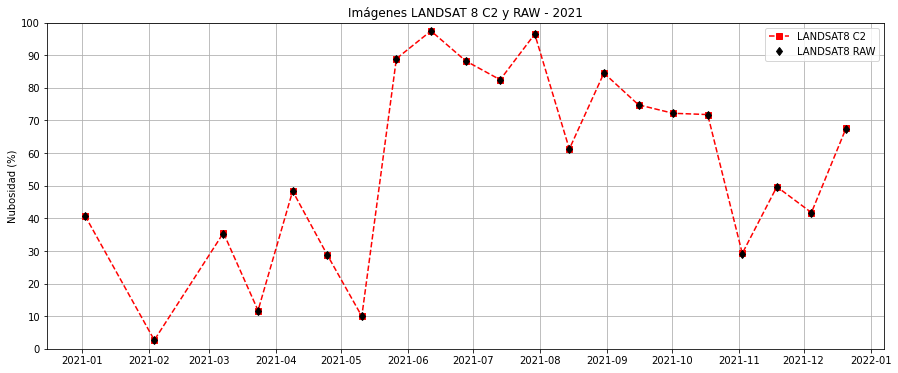

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'rs--', label='LANDSAT8 C2') 
plt.plot(reporteL8_RAW['Fecha Precisa'], reporteL8_RAW['CLOUD_COVER'], 'kd', label='LANDSAT8 RAW')

plt.title(f'Imágenes LANDSAT 8 C2 y RAW - {year}')
# Eje Y
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)
# Eje X
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

In [ ]:
mes = reporteL8_RAW['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL8_RAW), roi=fixed(chongoyape));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1), O…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


#### USGS Landsat 7 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1_L2)

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1_L2'
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL7_C2 = generar_reporte(icol_sr)
reporteL7_C2

ID GEE  ... ZENITH ANGLE
0   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210110  ...    41.576951
1   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210126  ...    42.291609
2   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210211  ...    42.370742
3   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210227  ...    42.155174
4   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210315  ...    42.093005
5   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210331  ...    42.565217
6   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210416  ...    43.780423
7   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210502  ...    45.623796
8   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210603  ...    49.796973
9   LANDSAT/LE07/C02/T1_L2/LE07_010065_20210619  ...    51.241992
10  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210705  ...    51.781028
11  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210721  ...    51.262064
12  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210806  ...    49.715637
13  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210822  ...    47.393137
14  LANDSAT/LE07/C02/T1_L2/LE07_010065_20210907  ...    44.714463
15  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211009  ...    40.590831
16  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211025  ...    40.167843
17  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211110  ...    41.045713
18  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211126  ...    42.889722
19  LANDSAT/LE07/C02/T1_L2/LE07_010065_20211212  ...    45.162630

[20 rows x 9 columns]

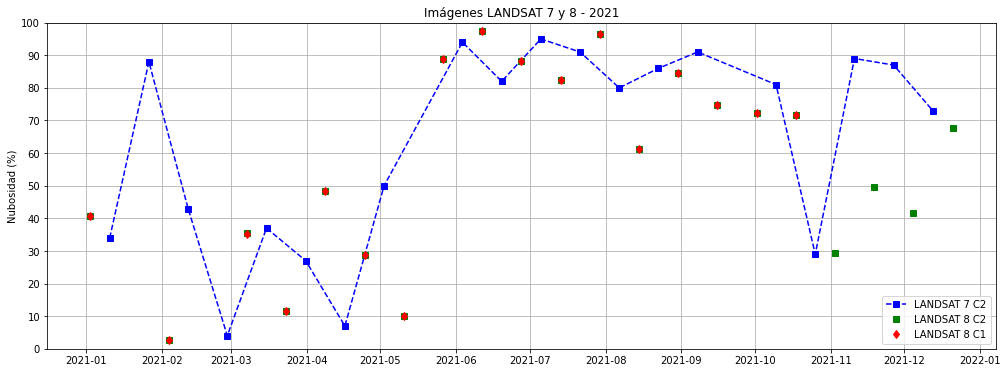

In [ ]:
plt.figure(figsize=(17,6))

plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 7 C2') 
plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT 8 C1')

plt.title(f'Imágenes LANDSAT 7 y 8 - {year}')
# Eje Y
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)
# Eje X
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

In [ ]:
mes = reporteL7_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL7_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1), O…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


#### USGS Landsat 5 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C02_T1_L2)

Datos disponibles desde `1984-01-01` - `2012-05-05` lo que conlleva a máximo 4 imágenes en el año 2008.

In [ ]:
snippet_name = 'LANDSAT/LT05/C02/T1_L2'
path = 10
row = 65
year = 2008

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL5_C2 = generar_reporte(icol_sr)
reporteL5_C2

ID GEE  ... ZENITH ANGLE
0  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080404  ...    33.887959
1  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080420  ...    35.686489
2  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080506  ...    38.092512
3  LANDSAT/LT05/C02/T1_L2/LT05_010065_20080709  ...    43.422773

[4 rows x 9 columns]

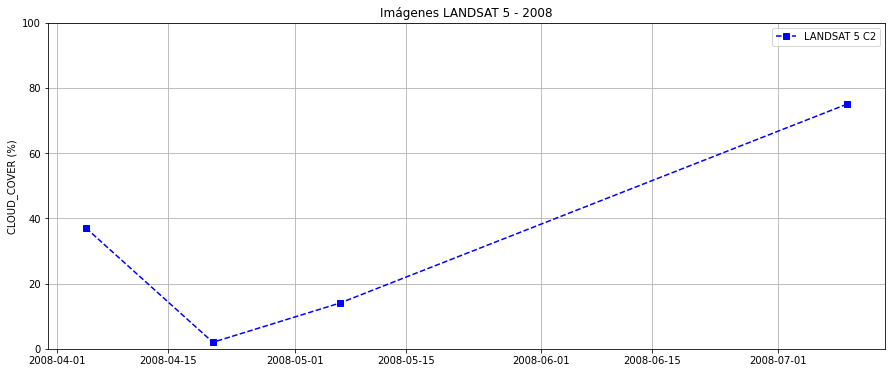

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(reporteL5_C2['Fecha Precisa'], reporteL5_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 5 C2') 
plt.title(f'Imágenes LANDSAT 5 - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
plt.grid(), plt.legend();

In [ ]:
mes = reporteL5_C2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteL5_C2), roi=fixed(chongoyape_bound));

interactive(children=(Dropdown(description='mes', options=(4, 5, 7), value=4), Output()), _dom_classes=('widge…

### Sentinel-2

In [ ]:
# Filtrado Sentinel-2
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = chongoyape_punto

icol_s2_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
)

reporteS2 = generar_reporte(icol_s2_sr)
reporteS2

ID GEE  ... CLOUDY_PIXEL_PERCENTAGE
0   COPERNICUS/S2_SR/20210101T153619_20210101T1544...  ...               60.175373
1   COPERNICUS/S2_SR/20210106T153621_20210106T1540...  ...               96.552039
2   COPERNICUS/S2_SR/20210111T153619_20210111T1537...  ...               14.484162
3   COPERNICUS/S2_SR/20210116T153621_20210116T1540...  ...               92.622773
4   COPERNICUS/S2_SR/20210121T153619_20210121T1537...  ...               27.849255
..                                                ...  ...                     ...
69  COPERNICUS/S2_SR/20211207T153619_20211207T1537...  ...               25.602575
70  COPERNICUS/S2_SR/20211212T153621_20211212T1541...  ...               15.497769
71  COPERNICUS/S2_SR/20211217T153609_20211217T1537...  ...               33.601699
72  COPERNICUS/S2_SR/20211222T153621_20211222T1541...  ...                5.458303
73  COPERNICUS/S2_SR/20211227T153619_20211227T1537...  ...               87.152607

[74 rows x 9 columns]

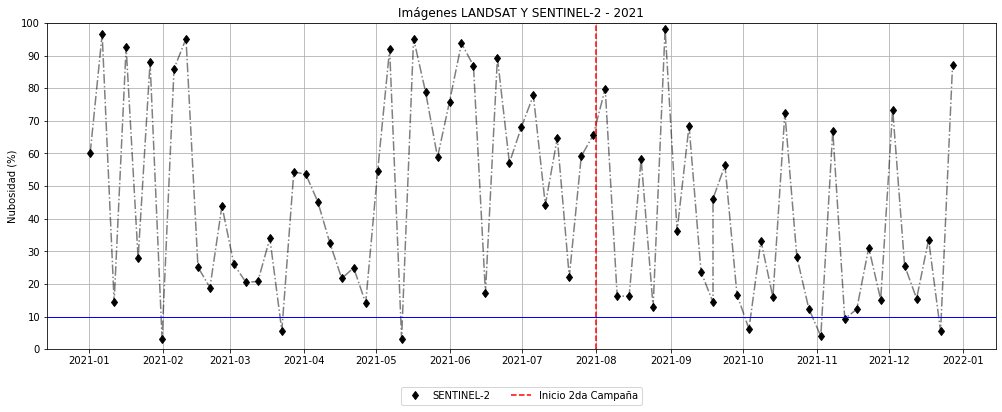

In [ ]:
plt.figure(figsize=(17, 6))

# Datos a visualizar
# plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'rs', label='LANDSAT 7 C2') 
# plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'kd', label='SENTINEL-2')
plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'k-.', alpha=0.5)

plt.axvline(x=pd.Timestamp('2021-8'), color='red', linestyle='--', label='Inicio 2da Campaña')

plt.title(f'Imágenes LANDSAT Y SENTINEL-2 - {year}')

# Eje Y
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)

# Eje X
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# Linea de filtrado (opcional)
plt.axhline(10, color = 'b', linewidth = '1') # Resaltar el 0

plt.grid(), plt.legend(bbox_to_anchor=(0.5, -0.1), ncol=4, loc="upper center");

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 9, 14, 19, 24
- Setiembre: 3, 13, 18 (problema de corte), 28
- Octubre: 23 y 28
- Noviembre: 2, 7, 17, 22 y 27
- Diciembre: 2


In [ ]:
mes = reporteS2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(reporteS2), roi=fixed(chongoyape));

Punto: https://www.facebook.com/Restaurant-Cevicher%C3%ADa-La-Cascada-476501522786440/

### DEM SRTM

Comparación de datasets DEM: SRTM vs ALOS

- [NASA SRTM Digital Elevation 30m](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003)
- [ALOS DSM: Global 30m](https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V2_2)

In [ ]:
# Comparación entre dems: SRTM y ALOS (scale= 30m)

roi = chongoyape_bound

srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)
alos = ee.Image("JAXA/ALOS/AW3D30/V2_2").select('AVE_DSM').clip(roi)

inferno_pal = ["#000004", "#560F6D", "#BB3654", "#F98C09", "#FCFFA4"]
Greys_r = ['000000', '212121', '484848', '686868', '868686', 'a7a7a7', 'c6c6c6', 'dedede', 'f2f2f2', 'ffffff']
vis_params = {'min':0, 'max':2000, 'palette': Greys_r}

# Visualización
Map = geemap.Map(height='800px') #basemap='HYBRID', layer_ctrl=True) # OpenStreetMap.Mapnik
# Map.setCenter(-70.61,-13.35, 10) #  Aquí se produce un fallo (comparar)
Map.centerObject(chongoyape_bound, 11)
Map.addLayer(srtm, vis_params, 'SRTM DEM')
Map.addLayer(alos, vis_params, 'ALOS DSM')
Map.addLayer(empty, {}, 'Distrito Chongoyape')

Map

### Datos Meteorológicos

Estación Meteorológica Tinajones

In [ ]:
# Datos de estación tinajones 2021 - Descargado mensualmente y agrupado en un solo archivo alojado en GitHub
path = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/Tinajones_datos_met_2021.csv'

df_tinajones = pd.read_csv(path, na_values='S/D')
df_tinajones['FECHA Larga'] = pd.to_datetime(df_tinajones['FECHA'] + ' ' + df_tinajones['HORA'], format='%Y-%m-%d %H:%M')
df_tinajones

FECHA   HORA  ...  VELOCIDAD DEL VIENTO (m/s)         FECHA Larga
0     2021-01-01  00:00  ...                         2.9 2021-01-01 00:00:00
1     2021-01-01  01:00  ...                         1.9 2021-01-01 01:00:00
2     2021-01-01  02:00  ...                         1.3 2021-01-01 02:00:00
3     2021-01-01  03:00  ...                         1.4 2021-01-01 03:00:00
4     2021-01-01  04:00  ...                         1.0 2021-01-01 04:00:00
...          ...    ...  ...                         ...                 ...
7993  2021-11-30  19:00  ...                         6.0 2021-11-30 19:00:00
7994  2021-11-30  20:00  ...                         4.9 2021-11-30 20:00:00
7995  2021-11-30  21:00  ...                         4.4 2021-11-30 21:00:00
7996  2021-11-30  22:00  ...                         4.3 2021-11-30 22:00:00
7997  2021-11-30  23:00  ...                         2.9 2021-11-30 23:00:00

[7998 rows x 8 columns]

In [ ]:
df_15_hr = df_tinajones[df_tinajones['HORA']=='15:00']

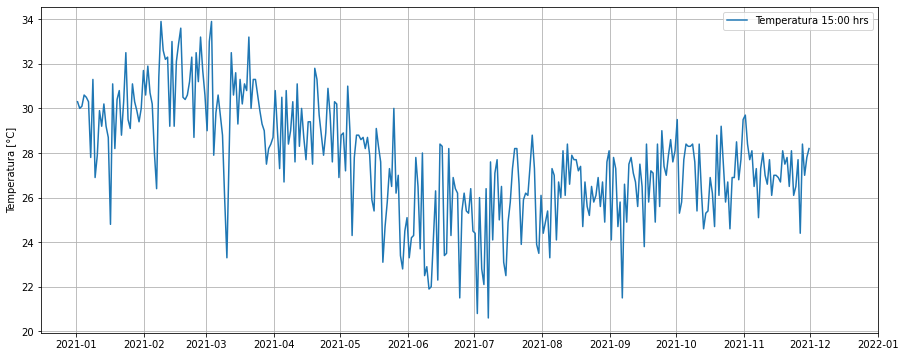

In [ ]:
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(df_15_hr['FECHA Larga'], df_15_hr['TEMPERATURA (degree C)'], label='Temperatura 15:00 hrs')
plt.ylabel('Temperatura [°C]')
plt.legend(loc=4)
# Eje Y derecho: requiere reporteL8_RAW
# plt.twinx().plot(reporteL8_RAW['Fecha Precisa'], reporteL8_RAW['CLOUD_COVER'], 'kd--', label='LANDSAT8 RAW')
# plt.ylim(0,100), plt.ylabel('Nubosidad [%]')

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_tinajones.FECHA, df_tinajones['PRECIPITACION (mm/hora)']);

###### Pruebas

In [ ]:
# Convertir las fechas 
from datetime import datetime
fechas = reporteL8_RAW['Fecha Corta'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
fechas

In [ ]:
for i in range(19):
  print(f"Fecha: {fechas[i]} y temperatura: {df_16_hr[ df_16_hr['FECHA'] == fechas[i] ]['TEMPERATURA (degree C)'].tolist()[0]}")

### Indices de Vegetación

#### Previo
- Funciones
- Paletas de colores
- Visualizador de índices

In [ ]:
# @markdown Indices de Vegetación:
# @markdown - NDVI
# @markdown   - Función `get_ndvi_S2(image)`
# @markdown   - Función `get_ndvi_L8_C1(image)`
# @markdown   - Función `get_ndvi_L8_C2(image)`
# @markdown   - Función `get_ndvi_L7(image)`
# @markdown - EVI
# @markdown   - Función `get_evi_S2(image)`

def get_ndvi_S2(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000)}).rename('NDVI')
  return image.addBands(ndvi)
  
def get_ndvi_L8_C1(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B5').divide(10000)}
       ).rename('NDVI')
  return image.addBands(ndvi)

def get_ndvi_L8_C2(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B4').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B5').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

def get_ndvi_L7(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B3').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B4').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

# def ndvi_icol(image):
#   ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
#   return image.addBands([ndvi])


def get_evi_S2(image):
  """
  https://developers.google.com/earth-engine/guides/image_math#expressions
  """
  evi = image.expression(
      '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000),
       'blue': image.select('B2').divide(10000)}
       ).rename('EVI')
  return image.addBands(evi)

In [ ]:
# @markdown Paletas de colores para NDVI y EVI

#------------- Paletas de NDVI ---------------------------------------
# @markdown - `BWG` : Blue, White, Green para valores -1 a 1
BWG = ['blue', 'white', 'green']

# @markdown - `GIMMS_NDVI` : GIMMS NDVI From AVHRR Sensors (3rd Generation)
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GIMMS_3GV0?hl=en
GIMMS_NDVI = ['000000', 'f5f5f5', '119701']

# @markdown - `MOD13A1` : MOD13A1.006 Terra Vegetation Indices 16-Day Global 500m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1?hl=en#description
MOD13A1 = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
]

# @markdown - `yuri_ndvi_pal` : Paleta NDVI (Yuri SIG) 20 Colores
yuri_ndvi_pal = [
    'ffffff', 'fffcff', 'fff9ff', 'fff7ff', 'fff4ff', 'fff2ff', 'ffefff',
    'ffecff', 'ffeaff', 'ffe7ff', 'ffe5ff', 'ffe2ff', 'ffe0ff', 'ffddff',
    'ffdaff', 'ffd8ff', 'ffd5ff', 'ffd3ff', 'ffd0ff', 'ffceff', 'ffcbff',
    'ffc8ff', 'ffc6ff', 'ffc3ff', 'ffc1ff', 'ffbeff', 'ffbcff', 'ffb9ff',
    'ffb6ff', 'ffb4ff', 'ffb1ff', 'ffafff', 'ffacff', 'ffaaff', 'ffa7ff',
    'ffa4ff', 'ffa2ff', 'ff9fff', 'ff9dff', 'ff9aff', 'ff97ff', 'ff95ff',
    'ff92ff', 'ff90ff', 'ff8dff', 'ff8bff', 'ff88ff', 'ff85ff', 'ff83ff',
    'ff80ff', 'ff7eff', 'ff7bff', 'ff79ff', 'ff76ff', 'ff73ff', 'ff71ff',
    'ff6eff', 'ff6cff', 'ff69ff', 'ff67ff', 'ff64ff', 'ff61ff', 'ff5fff',
    'ff5cff', 'ff5aff', 'ff57ff', 'ff55ff', 'ff52ff', 'ff4fff', 'ff4dff',
    'ff4aff', 'ff48ff', 'ff45ff', 'ff42ff', 'ff40ff', 'ff3dff', 'ff3bff',
    'ff38ff', 'ff36ff', 'ff33ff', 'ff30ff', 'ff2eff', 'ff2bff', 'ff29ff',
    'ff26ff', 'ff24ff', 'ff21ff', 'ff1eff', 'ff1cff', 'ff19ff', 'ff17ff',
    'ff14ff', 'ff12ff', 'ff0fff', 'ff0cff', 'ff0aff', 'ff07ff', 'ff05ff',
    'ff02ff', 'ff00ff', 'ff00ff', 'ff0af4', 'ff15e9', 'ff1fdf', 'ff2ad4',
    'ff35c9', 'ff3fbf', 'ff4ab4', 'ff55aa', 'ff5f9f', 'ff6a94', 'ff748a',
    'ff7f7f', 'ff8a74', 'ff946a', 'ff9f5f', 'ffaa55', 'ffb44a', 'ffbf3f',
    'ffc935', 'ffd42a', 'ffdf1f', 'ffe915', 'fff40a', 'ffff00', 'ffff00',
    'fffb00', 'fff700', 'fff300', 'fff000', 'ffec00', 'ffe800', 'ffe400',
    'ffe100', 'ffdd00', 'ffd900', 'ffd500', 'ffd200', 'ffce00', 'ffca00',
    'ffc600', 'ffc300', 'ffbf00', 'ffbb00', 'ffb700', 'ffb400', 'ffb000',
    'ffac00', 'ffa800', 'ffa500', 'ffa500', 'f7a400', 'f0a300', 'e8a200',
    'e1a200', 'd9a100', 'd2a000', 'ca9f00', 'c39f00', 'bb9e00', 'b49d00',
    'ac9c00', 'a59c00', '9d9b00', '969a00', '8e9900', '879900', '7f9800',
    '789700', '709700', '699600', '619500', '5a9400', '529400', '4b9300',
    '439200', '349100', '2d9000', '258f00', '1e8e00', '168e00', '0f8d00',
    '078c00', '008c00', '008c00', '008700', '008300', '007f00', '007a00',
    '007600', '007200', '006e00', '006900', '006500', '006100', '005c00',
    '005800', '005400', '005000', '004c00'
]

# @markdown - `RdYnIGn` : Paleta  para 6 rangos 0 - 0.6
RdYnIGn = ['a50026', 'f46d43', 'fee08b', 'd9ef8b', '66bd63', '006837']

#------------- Paletas de EVI ---------------------------------------
evi_palette = [
    'ffffff', 'fcd163', '99b718', '66a000', '3e8601', '207401', '056201',
    '004c00', '011301'
]

ndvi_palette = [
    "#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00",
    "#429001", "#006400", "#003B00", "#000000"
]

# @markdown Más paletas de colores:
# @markdown - [OpenWeather in Medium: Visualisation of the NDVI index on satellite maps. Custom palettes for agricultural applications](https://openweathermap.medium.com/visualisation-of-the-ndvi-index-on-satellite-maps-custom-palettes-for-agricultural-applications-f99b0652f991)

geemap también ofrece una gran cantidad de paletas!

In [ ]:
# @markdown Ver Indice Mensual: `ver_indice_mensual(df, indice, mes, img)`
def ver_indice_mensual(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)

  # if imagen_str in ['LANDSAT/LC08/C02/T1_L2', 'LANDSAT/LE07/C02/T1_L2']:
  #   imagen_rgb = imagen_ee.multiply(0.0000275).add(-0.2)
  # else: 
  #   
  imagen_rgb = imagen_ee.multiply(0.0001)

  if indice == 'ndvi':
    imagen_indice = get_ndvi_S2(imagen_ee).select(['NDVI'])
  elif indice == 'evi':
    imagen_indice = get_evi_S2(imagen_ee).select(['EVI'])
  elif indice == 'savi':
    imagen_indice = get_savi_L8(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}/{imagen_str[23:25]}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':0, 'max':1, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.split_map(left_layer, right_layer)
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(roi, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

Escala de NDVI y EVI: -0.2 a 1

#### NDVI

##### Sentinel-2

Para usar la herramienta Inspector es necesario solo tener una imagen visualizada. 

In [ ]:
mes = reporteS2['Mes'].unique().tolist()
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['ndvi','evi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

##### Landsat

In [ ]:
# @markdown Ver Indice Mensual: `ver_indice_mensual_L8(df, indice, mes, img)`
def ver_indice_mensual_L8(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)
 
  imagen_rgb = imagen_ee.multiply(0.0001)

  # if indice == 'ndvi':
  imagen_indice = get_ndvi_L8_C1(imagen_ee).select(['NDVI'])
  # elif indice == 'evi':
  #   imagen_indice = get_evi_L8_C1(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}, ID: {imagen_str}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':0, 'max':1, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.split_map(left_layer, right_layer)
  # Map.addLayer(imagen_rgb.clip(roi), vis_rgb, 'RGB') # roiChongoyapeDraw
  # Map.addLayer(imagen_indice.clip(roi), viz_params, indice.upper()) # roiChongoyapeDraw
  Map.addLayer(roi, {'color':'00FF00'}, 'ROI') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

In [ ]:
mes = reporteL8_C1['Mes'].unique().tolist()
interact(ver_indice_mensual_L8, df=fixed(reporteL8_C1), indice=fixed('ndvi'), mes=mes, img=(1,2,1), roi=fixed(chongoyape_bound));

#### EVI

In [ ]:
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['evi', 'ndvi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

### Aplicando reducciones: NDVI

Objetivos:
- Obtener una gráfica de valores de NDVI para la zona de evaluación a partir de imágenes Sentinel-2 SR.

  Fuente: [Time Series Visualization with Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair)

#### Funciones

In [ ]:
# @markdown Función `def create_reduce_region_function`

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326'):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# @markdown Función `fc_to_dict(fc)`

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# @markdown Función `add_date_info(df)`

# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
import altair as alt

#### Proceso

##### Sentinel-2

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
# roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

# parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2
roi = chongoyape.geometry() # No olvidar que debe ser un ee.Geometry()

s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
    # .map(maskS2clouds) # Incluye el dividir por 10000
    .map(get_ndvi_S2)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=roi, reducer=ee.Reducer.max(), scale=10)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
df_sin_mask = s2_parcelas_df.copy()

In [ ]:
# Visualización
plt.figure(figsize=(15,6))
plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
# plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}')
plt.ylabel('NDVI values'), plt.ylim(top=1)

plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(df_sin_mask).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

In [ ]:
df_ag_dic =  s2_parcelas_df.copy()

##### Landsat 8

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LC08/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L8)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
# df_sin_mask = s2_parcelas_df.copy()

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

# plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
# plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'bd-', label='Landsat8')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.xlabel('Fechas'), plt.ylabel('NDVI values')
# plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
# plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
# plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(top=1)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

##### Landsat 7

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L7)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'kd-', label='Landsat8')
plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER']/100, 'bs-.') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.ylabel('NDVI values'), plt.ylim(top=1)

plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)

plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

# Procesamiento de imágenes Landsat 8 Raw Scenes

## Conversión de ND a Reflectancia al tope de la atmósfera TOA

> Landsat Collections Level-1 data can be rescaled to top of atmosphere (TOA) reflectance and/or radiance using radiometric rescaling coefficients provided in the metadata file that is delivered with the Level-1 product. The metadata file also contains the thermal constants needed to convert thermal band data to TOA brightness temperature. Formulas for these conversions are provided on this page. [Fuente](https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product)



|Name	|Pixel |Size	  |Wavelength	    | Description |
|-|-|-|-|-|
|B1	  |30    |meters	|0.43 - 0.45 µm	| Coastal aerosol |
|B2	  |30    |meters	|0.45 - 0.51 µm	| Blue |
|B3	  |30    |meters	|0.53 - 0.59 µm	| Green |
|B4	  |30    |meters	|0.64 - 0.67 µm	| Red |
|B5	  |30    |meters	|0.85 - 0.88 µm	| Near infrared |
|B6	  |30    |meters	|1.57 - 1.65 µm	| Shortwave infrared 1 |
|B7	  |30    |meters	|2.11 - 2.29 µm	| Shortwave infrared 2 |
|B8	  |15    |meters	|0.52 - 0.90 µm	| Band 8 Panchromatic |
|B9	  |15    |meters	|1.36 - 1.38 µm	| Cirrus |
|B10	|30    |meters	|10.60 - 11.19 µm | Thermal infrared 1, resampled from 100m to 30m |
|B11	|30    |meters	|11.50 - 12.51 µm | Thermal infrared 2, resampled from 100m to 30m |
|BQA	|30    |meters	|                |Landsat Collection 1 QA Bitmask (See Landsat QA page) |

Las imágenes Landsat 8 consisten en una serie cuantificada y calibrada de niveles digitales que **pueden ser reescalados a valores de radiancia y reflectancia** usando para ello los coeficientes radiométricos provistos en el archivo de metadato (_MTL.txt), tal y como se describe a continuación:

$$
L_\lambda = \text{ML}*\text{Qcal}+\text{AL}
$$

Dónde:

- $L_\lambda$: Radiancia espectral en el sensor (Radiancia en el satélite).
- $\text{Qcal}$: Valor de pixel discretizados y calibrados del producto estándar (Valor digitales DN).
- $\text{ML}$: Factor Multiplicativo de reescalamiento específico de la banda, proveniente de los metadatos (RADIANCE_MULT_BAND_x, donde x es el número de banda).
- $\text{AL}$: Factor Aditivo de reescalamiento específico de la banda, proveniente de los metadatos (RADIANCE_ADD_BAND_x, donde x es el número de banda).

- [Propiedades de Landsat 8 Raw](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1#image-properties)

In [ ]:
# @markdown Función `convertir_TOA(img)` \
# @markdown - **Nota**: Debido a la correción realizada, ya no es necesario
# @markdown aplicarsele el factor de escala 0.00001

import math 
def convertir_TOA(img):
  sun_elev = ee.Number(img.get('SUN_ELEVATION')).multiply(math.pi / 180)
  for i in range(1,8):
    reflectance_mult_band_x = ee.Number(img.get(f'REFLECTANCE_MULT_BAND_{i}'))
    reflectance_add_band_x =  ee.Number(img.get(f'REFLECTANCE_ADD_BAND_{i}'))
    band = (
        img.select(f'B{i}')
        .multiply(reflectance_mult_band_x)
        .add(reflectance_add_band_x)
        .divide(sun_elev.sin())
    )
    img = img.addBands(band, None, True)
  return img

# id = 'LANDSAT/LC08/C01/T1/LC08_010065_20210713'
# image = ee.Image(id)
# convertir_TOA(image).bandNames().getInfo()

In [ ]:
snippet_name = "LANDSAT/LC08/C01/T1"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

image_con = icol_sr.map(convertir_TOA).first().select(['B[1-7]'])
image_sin = icol_sr.first().select(['B[1-7]']).multiply(0.00001)

Map = geemap.Map(layer_ctrl=True)
Map.centerObject(chongoyape, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(image_sin, {'min':0,'max':0.3,'bands':['B4','B3','B2']},'RAW Image')
Map.addLayer(image_con, {'min':0,'max':0.3,'bands':['B4','B3','B2']},'TOA Image')
Map.addLayer(empty, {}, name = 'Chongoyape')
Map

#### Prueba: Algoritmos de Landsat en Earth Engine

- [Landsat Algorithms](https://developers.google.com/earth-engine/guides/landsat)

In [ ]:
snippet_name = "LANDSAT/LC08/C01/T1"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

# Load a raw Landsat scene and display it. 
raw = icol_sr.first() #ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20210713')

# Convert the raw data to top-of-atmosphere reflectance.
toa = ee.Algorithms.Landsat.TOA(raw) # help(ee.Algorithms.Landsat.TOA)

Map = geemap.Map(layer_ctrl=True)
Map.centerObject(raw, 10);
Map.addLayer(raw, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 30000}, 'raw');
Map.addLayer(toa, {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}, 'toa reflectance');
Map

- Comparación: Mi función con `ee.Algorithms.Landsat.TOA`

In [ ]:
# Para imagecollection
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
img_toa = ee.Algorithms.Landsat.TOA(img_ee) # Calibrates Landsat DN to TOA reflectance and brightness temperature for Landsat and similar data.

In [ ]:
# ND
img_ee.select('B10').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'B10_max': 32999, 'B10_min': 25131}

In [ ]:
# Temperatura de brillo
img_toa.select('B10').subtract(273.15).reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'B10_max': 37.14556274414065, 'B10_min': 18.885003662109398}

In [ ]:
# Valor de Radiancia
raw_to_TOA_Radiance_Reflectance(img_ee).select('B10').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'B10_max': 11.1282658, 'B10_min': 8.498780199999999}

- USGS Landsat 8 Collection 1 Tier 1 TOA Reflectance [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA)

### Índices de vegetación

#### Funciones

In [ ]:
# @markdown Función `convertir_TOA(img)` \
# @markdown - **Nota**: Debido a la correción realizada, ya no es necesario
# @markdown aplicarsele el factor de escala 0.00001

import math 
def convertir_TOA(img):
  sun_elev = ee.Number(img.get('SUN_ELEVATION')).multiply(math.pi / 180)
  for i in range(1,8):
    reflectance_mult_band_x = ee.Number(img.get(f'REFLECTANCE_MULT_BAND_{i}'))
    reflectance_add_band_x =  ee.Number(img.get(f'REFLECTANCE_ADD_BAND_{i}'))
    band = (
        img.select(f'B{i}')
        .multiply(reflectance_mult_band_x)
        .add(reflectance_add_band_x)
        .divide(sun_elev.sin())
    )
    img = img.addBands(band, None, True)
  return img

# id = 'LANDSAT/LC08/C01/T1/LC08_010065_20210713'
# image = ee.Image(id)
# convertir_TOA(image).bandNames().getInfo()

In [ ]:
# @markdown Funciones aplicables a Landsat8 TOA
# @markdown - NDVI: Función `get_ndvi_L8(image)`
# @markdown - SAVI: Función `get_savi_L8(image)`
# @markdown - EVI : Función `get_evi_L8(image)`

def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5')}
       ).rename('NDVI')
  return image.addBands(ndvi)

# https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
def get_savi_L8(image):
  savi = image.expression(
      '(nir - red) / (nir + red + L) * (1+L)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'L'   : ee.Number(0.1)}
       ).rename('SAVI')
  return image.addBands(savi)

def get_evi_L8(image):
  evi = image.expression(
      '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'blue': image.select('B2')}
       ).rename('EVI')
  return image.addBands(evi)

#### Prueba

In [ ]:
snippet_name = "LANDSAT/LC08/C01/T1" # Raw Scenes
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_raw = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_RAW = generar_reporte(icol_raw)
reporteL8_RAW

In [ ]:
# @markdown Ver Indice Mensual para Landsat 8
# @markdown - Función: `ver_indice_mensual(df, indice, mes, img)`
def ver_indice_mensual(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)
  nubosidad = imagen_ee.get('CLOUD_COVER').getInfo()

  # Información
  print(f'Fecha: {mes}/{imagen_str[-2:]}')
  print(f'% Nubosidad: {nubosidad:.3f}')

  imagen_rgb = convertir_TOA(imagen_ee)

  # Indices
  if indice == 'NDVI':
    imagen_indice = get_ndvi_L8(imagen_ee).select(['NDVI'])
  elif indice == 'EVI':
    imagen_indice = get_evi_L8(imagen_ee).select(['EVI'])
  elif indice == 'SAVI':
    imagen_indice = get_savi_L8(imagen_ee).select(['SAVI'])

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  RdYnIGn = ['a50026', 'f46d43', 'fee08b', 'd9ef8b', '66bd63', '006837']
  viz_params = {'min':0, 'max':0.6, 'palette': RdYnIGn} #RdYnIGn

  # left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  # right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice)

  empty = ee.Image().paint(chongoyape, 3,5) # https://github.com/google/earthengine-api/blob/6445cae4c371a8244f70ae08c01a6da05dbc4c7d/python/examples/py/FeatureCollection/from_polygons.py

  Map = geemap.Map(height='650px')
  # Map.split_map(left_layer, right_layer)
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw
  Map.addLayer(imagen_rgb.clip(roi), vis_rgb, 'RGB') 
  Map.addLayer(imagen_indice.clip(roi), viz_params, indice) 
  Map.addLayer(empty, {}, 'Chongoyape', opacity=1)

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

In [ ]:
mes = reporteL8_RAW['Mes'].unique().tolist()
interact(ver_indice_mensual, df=fixed(reporteL8_RAW), indice=['NDVI','SAVI','EVI'], mes=mes, img=(1,2,1), roi=fixed(chongoyape_bound));

# Balance de Energía Superficial - Modelo METRIC

##### Funciones Radiación Neta

In [38]:
# @markdown Función `convert_RAW_to_TOA(img)` \
# @markdown - **Nota**: Debido a la correción realizada, ya no es necesario
# @markdown aplicarsele el factor de escala 0.00001

import math 
def convert_RAW_to_TOA(img):
  """
  Conversión de imágenes RAW a Radiancia y Reflectancia
  al tope de la atmósfera (TOA)

  Reflectancia TOA: B, G, R, NIR, SWIR1, SWIR2 
  Radiancia TOA: B10
  """
  # TOA Reflectance for Bands R, G, B, Nir
  
  sun_elev = ee.Number(img.get('SUN_ELEVATION')).multiply(math.pi / 180)
  
  for i in range(2,8): # B, G, R, NIR, SWIR1, SWIR2
    reflectance_mult_band_x = ee.Number(img.get(f'REFLECTANCE_MULT_BAND_{i}'))
    reflectance_add_band_x =  ee.Number(img.get(f'REFLECTANCE_ADD_BAND_{i}'))
    band = (
        img.select(f'B{i}')
        .multiply(reflectance_mult_band_x)
        .add(reflectance_add_band_x)
        .divide(sun_elev.sin())
    )
    img = img.addBands(band, None, True)
  
  # TOA Radiance for Thermal Band B10 
  # RADIANCE_MULT_BAND_10 & 11 = 3.3420E-04
  # RADIANCE_ADD_BAND_10  & 11 = 0.1

  b10 = img.select(['B10']).multiply(3.3420E-04).add(0.1)
  
  img = img.addBands(b10, None, True).select(
      ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'])

  return img # Sobreescribir

In [39]:
# @markdown Índices de vegetación aplicables a Landsat8 TOA
# @markdown - NDVI: Función `get_ndvi_L8(image)`
# @markdown - SAVI: Función `get_savi_L8(image)` **(Se está tomando el valor de 0.5 para L)**
# @markdown - LAI : Función `get_lai_l8(image)`
## @markdown - EVI : Función `get_evi_L8(image)`

def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5')}
       ).rename('NDVI')
  return image.addBands(ndvi)

# https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
def get_savi_L8(image):
  savi = image.expression(
      '(nir - red) / (nir + red + L) * (1+L)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'L'   : ee.Number(0.5)}
       ).rename('SAVI')
  return image.addBands(savi)

def get_lai_L8(image):
  lai = image.expression(
      '- (log((0.69 - savi)/0.59))/(0.91)',
      {'savi' : image.select('SAVI')}
       ).rename('LAI')
  return image.addBands(lai)
  
# def get_evi_L8(image):
#   evi = image.expression(
#       '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
#       {'red' : image.select('B4'),
#        'nir' : image.select('B5'),
#        'blue': image.select('B2')}
#        ).rename('EVI')
#   return image.addBands(evi)

In [40]:
# @markdown Paletas de Visualización
ndvi_palete = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
ndvi_palete2 = ["#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
RdYnIGn = ['#051852','a50026', 'e34a33', 'fca55d', 'fee99a', 'e4f49a', '9dd569', '3ba858', '006837']
RdYnIGn_r = ['006837', '3ba858', '9dd569', 'e4f49a', 'fee99a', 'fca55d', 'e34a33', 'a50026']

vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
vis_ndvi = {'min': 0.0, 'max': 0.7, 'palette': ndvi_palete2} 
viz_lai = {'min': 0, 'max': 3, 'palette': RdYnIGn} 

In [41]:
# @markdown Función `get_decl_lat_hra(img, roi, doy)` 

# @markdown **Retorna**: 
# @markdown - `angl_decl` (ee.Number) en radianes
# @markdown - `latitud` (ee.Image) en radianes
# @markdown - `angle_hra` (ee.Image) en radianes

def get_decl_lat_hra(img, roi, doy): 

  # Datos a partir de imagen satelital
  # doy = img.date().getRelative('day', 'year') # ee.Number 
  proj = img.select([0]).projection() # EPSG:32617 -> WGS 84 / UTM zone 17N

  img_lonlat = ee.Image.pixelLonLat().reproject(proj).clip(roi) # ee.Image con bandas 'Longitude' y 'Latitude'

  factor_rad = ee.Number(math.pi/180) # Factor de conversión a radianes

  # Declinacion δ: ee.Number en radianes
  angl_decl = ee.Number.expression(
      '-23.45*cos( 360*(d+10)/365 * factor )', 
      {'d':doy, 'factor':factor_rad}).multiply(factor_rad) 

  # Latitud ϕ: ee.Number en radianes
  latitud = img_lonlat.select('latitude').multiply(factor_rad)

  # Angulo horario: ee.Number
  B   = ee.Number.expression(
      '360/365*(doy-81)', {'doy': doy}).multiply(factor_rad) # radianes
  eot = ee.Number.expression(
      '9.87*sin(2*B) - 7.53*cos(B) - 1.5*sin(B)', {'B': B}) # en minutos 
  
  longitud = img_lonlat.select('longitude') # en grados 

  tc  = longitud.expression(
      '4*(long-(-75)) + eot', 
      {'eot': eot, 'long':longitud}) # -75 = 15° * -5 = LSTM , -5 viene de 15hrs - 20hrs del Greenwich Mean Time

  hr  = img.date().get('hour') # 15 para Landsat 8
  min = img.date().get('minute')
  lt  = hr.add(min.divide(60)) # hr + min/60

  lst = tc.divide(60).add(lt)

  angle_hra = lst.subtract(12).multiply(15).rename('angle_hra').multiply(factor_rad) # radianes

  return angl_decl, latitud, angle_hra

In [42]:
# @markdown 4. Función `get_emisividades(img_ndvi, img_savi, img_lai)` 

# Emisividad de banda estrecha / Narrow band emissivity
def get_emisividades(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  Retorna:
  - e_nb, e_0 : dos imágenes de emisividad 
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb') # e_nb = 0.985 
  e_0_0985  = ndvi_lte0.multiply(0.985).rename('e_0')  # e_0  = 0.985

  # Emisividades para LAI > 3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb') # e_nb = 0.98
  e_0_098  = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_0')  # e_0  = 0.98

  # Emisividades para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) que representa LAI <= 3 y NDVI > 0 
  condicional = ndvi_gt0.subtract(lai_gt3) # NDVI > 0 y excluye los valores de LAI > 3 obteniendose el LAI <= 3 y NDVI > 0
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( condicional ).rename('e_nb') # e_nb = 0.97 + 0.0033 LAI   
  e_0_eq = lai_lte3.multiply(0.01).add(0.95).multiply( condicional ).rename('e_0')    # e_0 = 0.95 + 0.01 LAI 
  
  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)
  e_0 = e_0_098.add(e_0_0985).add(e_0_eq)

  return e_nb, e_0

In [43]:
# @markdown 3. Función `get_surface_temp(img_toa, e_nb)` en grados Kelvin

def get_surface_temp(img_toa, e_nb):

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', 
                          {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',
                     {'e_nb':e_nb, 'rc':rc}).rename('ts')
  
  return ts

In [44]:
# @markdown Función: `convert_TOA_to_SR(img_toa, P_air
# @markdown , w, cos_theta_hor)`

# @markdown **Retorna:**
# @markdown  - Imagen con bandas:
# @markdown `['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR']`
 
def convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor):

  """Conversión de imagen TOA a Reflectancia de Superficie
  En METRIC se deriva la reflectancia de superficie bidireccional 
  utilizando funciones calibradas de transmitancia atmosférica 
  y reflectancia de la trayectoria por Tasumi et al. (2007).

  Se corrige los valores de las bandas de la imagen TOA para la 
  dispersión y absorción de la radiación solar entrante y 
  reflejada desde la superficie, basándose en una función de 
  corrección atmosférica simplificada que sólo requiere mediciones
  puntuales o estimaciones de la presión de vapor cerca
  de la superficie. 
  """
  bands = ['B2','B3','B4','B5','B6','B7']

  img_toa = img_toa.select(bands)
  
  for b in bands:
    if b == 'B2':
      C1 = 0.987
      C2 = -0.00071
      C3 = 0.000036
      C4 = 0.0880
      C5 = 0.0789
      Cb = 0.640

    elif b == 'B3':
      C1 = 2.319
      C2 = -0.00016
      C3 = 0.000105
      C4 = 0.0437
      C5 = -1.2697
      Cb = 0.310

    elif b == 'B4':
      C1 = 0.951
      C2 = -0.00033
      C3 = 0.00028
      C4 = 0.0875
      C5 = 0.1014
      Cb = 0.286

    elif b == 'B5':
      C1 = 0.375
      C2 = -0.00048
      C3 = 0.005018
      C4 = 0.1355
      C5 = 0.6621
      Cb = 0.189

    elif b == 'B6':
      C1 = 0.234
      C2 = -0.00101
      C3 = 0.004336
      C4 = 0.0560
      C5 = 0.7757
      Cb = 0.274

    elif b == 'B7':
      C1 = 0.365
      C2 = -0.00097
      C3 = 0.004296
      C4 = 0.0155
      C5 = 0.639
      Cb = -0.186

    t_in_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': cos_theta_hor}
         ).rename(f't_in_{b}')

    t_out_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': 1}
         ).rename(f't_out_{b}')

    R_in_s_b = t_in_b.multiply(t_out_b)

    R_out_s_b = img_toa.expression(
        'b - Cb*(1-t_in_b)', 
        {'Cb':Cb, 't_in_b': t_in_b, 'b':img_toa.select(b)}
    )

    p_s_b = R_out_s_b.divide(R_in_s_b)

    img_toa = img_toa.addBands(p_s_b, None, True)

  img_toa = (
      img_toa.select(bands)
      .rename(['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR'])
      )

  return img_toa

In [45]:
# @markdown Función: `get_albedo(image)`

def get_albedo(img_sr):
  """
  Obtener el albedo de una imagen mediante una calibración con 
  coeficientes de ponderación por banda (Da Silva et al., 2016)
  https://www.scielo.br/j/rbeaa/a/sX6cJjNXWMfHQ5p4h33B8Zz/?lang=en

  Argumentos:
      image (ee.Image) : Imagen satelital de Earth Engine.

  Retorna: 
      albedo (ee.Image) : Albedo de una imagen satelital. 
      
  """
  # paper 1:
  # '(0.3*B2 + 0.277*B3 + 0.233*B4 + 0.143*B5 + 0.036*B6 + 0.012*B7)'

  # Expresión para obtener el albedo
  albedo = img_sr.expression(
      '(0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7)',
      {
          'B2' : img_sr.select('B2_SR'),
          'B3' : img_sr.select('B3_SR'),
          'B4' : img_sr.select('B4_SR'),
          'B5' : img_sr.select('B5_SR'),
          'B6' : img_sr.select('B6_SR'),
          'B7' : img_sr.select('B7_SR')
      }
  ).rename('albedo')

  return img_sr.addBands(albedo)

## Funciones

In [14]:
# @markdown Assets: Departamentos, Provincias y Distritos
# Ejemplo de filtrado

# Assets
asset_departamentos = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_provincias = ee.FeatureCollection('users/CesarVilca/provincias')
asset_distritos = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
lambayeque = asset_departamentos.filterMetadata('DEPARTAMEN','equals','LAMBAYEQUE')
chiclayo = asset_provincias.filterMetadata('PROVINCIA','equals','CHICLAYO')
chongoyape = asset_distritos.filterMetadata('DISTRITO','equals','CHONGOYAPE')

# Punto
chongoyape_punto = ee.Geometry.Point([-79.389, -6.639])
chongoyape_bound = chongoyape.geometry().bounds() # CAJA

roi = chongoyape_bound
empty = ee.Image().paint(chongoyape, 2,2)
empty2 = ee.Image().paint(chongoyape_bound, 2, 2)

# Zona de evaluación
parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")
# parcelas_chongoyape.geometry().centroid().coordinates().getInfo()

In [ ]:
# @markdown Función `convert_RAW_to_TOA(img)` \
# @markdown - **Nota**: Debido a la correción realizada, ya no es necesario
# @markdown aplicarsele el factor de escala 0.00001

import math 
def convert_RAW_to_TOA(img):
  """
  Conversión de imágenes RAW a Radiancia y Reflectancia
  al tope de la atmósfera (TOA)

  Reflectancia TOA: B, G, R, NIR, SWIR1, SWIR2 
  Radiancia TOA: B10
  """
  # TOA Reflectance for Bands R, G, B, Nir
  
  sun_elev = ee.Number(img.get('SUN_ELEVATION')).multiply(math.pi / 180)
  
  for i in range(2,8): # B, G, R, NIR, SWIR1, SWIR2
    reflectance_mult_band_x = ee.Number(img.get(f'REFLECTANCE_MULT_BAND_{i}'))
    reflectance_add_band_x =  ee.Number(img.get(f'REFLECTANCE_ADD_BAND_{i}'))
    band = (
        img.select(f'B{i}')
        .multiply(reflectance_mult_band_x)
        .add(reflectance_add_band_x)
        .divide(sun_elev.sin())
    )
    img = img.addBands(band, None, True)
  
  # TOA Radiance for Thermal Band B10 
  # RADIANCE_MULT_BAND_10 & 11 = 3.3420E-04
  # RADIANCE_ADD_BAND_10  & 11 = 0.1

  b10 = img.select(['B10']).multiply(3.3420E-04).add(0.1)
  
  img = img.addBands(b10, None, True).select(
      ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'])

  return img # Sobreescribir

In [ ]:
# @markdown Paletas de Visualización
ndvi_palete = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
ndvi_palete2 = ["#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
RdYnIGn = ['#051852','a50026', 'e34a33', 'fca55d', 'fee99a', 'e4f49a', '9dd569', '3ba858', '006837']
RdYnIGn_r = ['006837', '3ba858', '9dd569', 'e4f49a', 'fee99a', 'fca55d', 'e34a33', 'a50026']

vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
vis_ndvi = {'min': 0.0, 'max': 0.7, 'palette': ndvi_palete2} 
viz_lai = {'min': 0, 'max': 3, 'palette': RdYnIGn} 

In [ ]:
# @markdown Índices de vegetación aplicables a Landsat8 TOA
# @markdown - NDVI: Función `get_ndvi_L8(image)`
# @markdown - SAVI: Función `get_savi_L8(image)` **(Se está tomando el valor de 0.5 para L)**
# @markdown - LAI : Función `get_lai_l8(image)`
## @markdown - EVI : Función `get_evi_L8(image)`

def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5')}
       ).rename('NDVI')
  return image.addBands(ndvi)

# https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
def get_savi_L8(image):
  savi = image.expression(
      '(nir - red) / (nir + red + L) * (1+L)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'L'   : ee.Number(0.5)}
       ).rename('SAVI')
  return image.addBands(savi)

def get_lai_L8(image):
  lai = image.expression(
      '- (log((0.69 - savi)/0.59))/(0.91)',
      {'savi' : image.select('SAVI')}
       ).rename('LAI')
  return image.addBands(lai)
  
# def get_evi_L8(image):
#   evi = image.expression(
#       '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
#       {'red' : image.select('B4'),
#        'nir' : image.select('B5'),
#        'blue': image.select('B2')}
#        ).rename('EVI')
#   return image.addBands(evi)

#### Funciones: Incoming Solar Radiation $R_{S\downarrow}$ 

1. Coseno del ángulo de incidencia solar $\theta_{rel}$ 

In [ ]:
# @markdown Función `get_decl_lat_hra(img, roi, doy)` 

# @markdown **Retorna**: 
# @markdown - `angl_decl` (ee.Number) en radianes
# @markdown - `latitud` (ee.Image) en radianes
# @markdown - `angle_hra` (ee.Image) en radianes

def get_decl_lat_hra(img, roi, doy): 

  # Datos a partir de imagen satelital
  # doy = img.date().getRelative('day', 'year') # ee.Number 
  proj = img.select([0]).projection() # EPSG:32617 -> WGS 84 / UTM zone 17N

  img_lonlat = ee.Image.pixelLonLat().reproject(proj).clip(roi) # ee.Image con bandas 'Longitude' y 'Latitude'

  factor_rad = ee.Number(math.pi/180) # Factor de conversión a radianes

  # Declinacion δ: ee.Number en radianes
  angl_decl = ee.Number.expression(
      '-23.45*cos( 360*(d+10)/365 * factor )', 
      {'d':doy, 'factor':factor_rad}).multiply(factor_rad) 

  # Latitud ϕ: ee.Number en radianes
  latitud = img_lonlat.select('latitude').multiply(factor_rad)

  # Angulo horario: ee.Number
  B   = ee.Number.expression(
      '360/365*(doy-81)', {'doy': doy}).multiply(factor_rad) # radianes
  eot = ee.Number.expression(
      '9.87*sin(2*B) - 7.53*cos(B) - 1.5*sin(B)', {'B': B}) # en minutos 
  
  longitud = img_lonlat.select('longitude') # en grados 

  tc  = longitud.expression(
      '4*(long-(-75)) + eot', 
      {'eot': eot, 'long':longitud}) # -75 = 15° * -5 = LSTM , -5 viene de 15hrs - 20hrs del Greenwich Mean Time

  hr  = img.date().get('hour') # 15 para Landsat 8
  min = img.date().get('minute')
  lt  = hr.add(min.divide(60)) # hr + min/60

  lst = tc.divide(60).add(lt)

  angle_hra = lst.subtract(12).multiply(15).rename('angle_hra').multiply(factor_rad) # radianes

  return angl_decl, latitud, angle_hra

In [ ]:
# @markdown Función `get_cos_theta_rel(dem, decl_angle, latitud, hra)` \

# @markdown **Requiere**: 
# @markdown - Función `get_decl_lat_hra(img, roi)`

def get_cos_theta_rel(dem, decl_angle, latitud, hra):
  
  factor_rad = ee.Number(math.pi/180) # Conversión a radianes

  # A partir del DEM: Pendiente y Aspect
  slope_rad = ee.Terrain.slope(dem).multiply(factor_rad)   # ee.Image 
  aspect_rad = ee.Terrain.aspect(dem).multiply(factor_rad) # ee.Image 

  # A partir de Imagen: Ángulos Declinación, Latitud y Horario en radianes
  # decl_angle, latitud, hra = get_decl_lat_hra(img, roi, doy) # ee.Number

  cos_theta_rel = slope_rad.select('slope').expression(
      """
      sin(delta)*sin(phi)*cos(s) - sin(delta)*cos(phi)*sin(s)*cos(gamma)
      + cos(delta)*cos(phi)*cos(s)*cos(omega)
      + cos(delta)*sin(phi)*sin(s)*cos(gamma)*cos(omega)
      + cos(delta)*sin(gamma)*sin(s)*sin(omega)
      """,
      {'delta': decl_angle,
      'phi': latitud,
      's': slope_rad.select('slope'),
      'gamma': aspect_rad.select('aspect'),
      'omega': hra}
  ).rename('cos_theta_rel') # ee.Image

  return cos_theta_rel

2. Broad-band Atmospheric Transmissivity $\tau_{sw}$

In [ ]:
# @markdown Función `get_e_nb(img_ndvi, img_savi, img_lai)`

def get_e_nb(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades
  # e_nb = 0.985 para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb')

  # e_nb = 0.98 para LAI >  3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb')

  # e_nb = 0.97 + 0.0033 LAI para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) con los valores requeridos de NDVI > 0 y LAI <= 3
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( ndvi_gt0.subtract(lai_gt3) ).rename('e_nb') 
  # LAI <= 3 (contiene valores de NDVI > 0 y LAI <= 3)
  # ndvi_gt0.subtract(lai_gt3) : NDVI > 0 y excluye los valores de LAI > 3 (mapas binarios)

  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)

  return e_nb

In [ ]:
# @markdown Función `get_surface_temp(img_toa, img_ndvi, img_savi, img_lai)` en grados Kelvin \

# @markdown **Requiere**:
# @markdown - Función `get_e_nb(img_ndvi, img_savi, img_lai)`

def get_surface_temp(img_toa, img_ndvi, img_savi, img_lai):

  # Emisividades
  e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', 
                          {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',
                     {'e_nb':e_nb, 'rc':rc}).rename('ts')
  
  return ts

In [ ]:
# @markdown Función `get_t_sw(dem, ts, decl_angle, latitud, hra)`

# @markdown **Requiere**: 
# @markdown - Función `get_decl_lat_hra(img, roi)`

def get_t_sw(P_air, ts, decl_angle, latitud, hra):

  cos_theta_hor = latitud.expression(
      'sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', 
      {'delta': decl_angle, 'phi': latitud, 'omega': hra})

  # 3. w Water in the atmosphere [mm]
  # Temperatura de superficie [°C]
  ts_c = ts.subtract(273.15) 

  # Near-surface vapor pressure ea [kPa]: Ojo ts en °C
  ea = ts_c.expression('6.112*exp(17.67 / (t + 243.5))', 
                       {'t' : ts_c.select('ts')}).rename('vapor_pressure')

  # Water in the atmosphere w
  w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

  # 4. t_sw
  t_sw = P_air.expression(
      '0.35 + 0.627*exp( -0.00146*P_air/(Kt*cos_theta_hor) - 0.075*(W/cos_theta_hor)**0.4 )', 
      {'P_air':P_air, 'Kt':1, 'cos_theta_hor': cos_theta_hor, 'W':w}).rename('t_sw')
  
  return t_sw

3. Square of the relative Earth–Sun distance $d^2$

In [ ]:
# @markdown Función `get_d2(img)`

def get_d2(img):
  doy = img.date().getRelative('day', 'year')
  factor = ee.Number(math.pi/180)
  d2 = ee.Number.expression('1/(1+0.033*cos(doy*2*pi/365))',
                            {'doy':doy, 'pi':math.pi, 'factor':factor})
  return d2

#### Funciones: Outgoing Long-Wave Radiation $R_{L\uparrow}$

In [25]:
# @markdown 1. Funciones aplicables a Landsat8 TOA
# @markdown - NDVI: Función `get_ndvi_L8(image)`
# @markdown - SAVI: Función `get_savi_L8(image)` **(Se está tomando el valor de 0.5 para L)**
# @markdown - LAI : Función `get_lai_l8(image)`
## @markdown - EVI : Función `get_evi_L8(image)`

def get_ndvi_L8(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5')}
       ).rename('NDVI')
  return image.addBands(ndvi)

# https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
def get_savi_L8(image):
  savi = image.expression(
      '(nir - red) / (nir + red + L) * (1+L)',
      {'red' : image.select('B4'),
       'nir' : image.select('B5'),
       'L'   : ee.Number(0.5)}
       ).rename('SAVI')
  return image.addBands(savi)

def get_lai_L8(image):
  lai = image.expression(
      '- (log((0.69 - savi)/0.59))/(0.91)',
      {'savi' : image.select('SAVI')}
       ).rename('LAI')
  return image.addBands(lai)
  
# def get_evi_L8(image):
#   evi = image.expression(
#       '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
#       {'red' : image.select('B4'),
#        'nir' : image.select('B5'),
#        'blue': image.select('B2')}
#        ).rename('EVI')
#   return image.addBands(evi)

In [26]:
# @markdown 2. Función `get_e_nb(img_ndvi, img_savi, img_lai)`

def get_e_nb(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades
  # e_nb = 0.985 para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb')

  # e_nb = 0.98 para LAI >  3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb')

  # e_nb = 0.97 + 0.0033 LAI para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) con los valores requeridos de NDVI > 0 y LAI <= 3
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( ndvi_gt0.subtract(lai_gt3) ).rename('e_nb') 
  # LAI <= 3 (contiene valores de NDVI > 0 y LAI <= 3)
  # ndvi_gt0.subtract(lai_gt3) : NDVI > 0 y excluye los valores de LAI > 3 (mapas binarios)

  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)

  return e_nb

In [27]:
# @markdown 3. Función `get_surface_temp(img_toa, e_nb)` en grados Kelvin

def get_surface_temp(img_toa, e_nb):

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', 
                          {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',
                     {'e_nb':e_nb, 'rc':rc}).rename('ts')
  
  return ts

In [28]:
# @markdown 4. Función `get_emisividades(img_ndvi, img_savi, img_lai)` 

# Emisividad de banda estrecha / Narrow band emissivity
def get_emisividades(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  Retorna:
  - e_nb, e_0 : dos imágenes de emisividad 
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb') # e_nb = 0.985 
  e_0_0985  = ndvi_lte0.multiply(0.985).rename('e_0')  # e_0  = 0.985

  # Emisividades para LAI > 3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb') # e_nb = 0.98
  e_0_098  = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_0')  # e_0  = 0.98

  # Emisividades para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) que representa LAI <= 3 y NDVI > 0 
  condicional = ndvi_gt0.subtract(lai_gt3) # NDVI > 0 y excluye los valores de LAI > 3 obteniendose el LAI <= 3 y NDVI > 0
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( condicional ).rename('e_nb') # e_nb = 0.97 + 0.0033 LAI   
  e_0_eq = lai_lte3.multiply(0.01).add(0.95).multiply( condicional ).rename('e_0')    # e_0 = 0.95 + 0.01 LAI 
  
  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)
  e_0 = e_0_098.add(e_0_0985).add(e_0_eq)

  return e_nb, e_0

In [29]:
# @markdown 5. Función `rad_l_up(e_0, ts)`
# @markdown - Retorna mapa de Radiación de onda larga saliente $R_{L\uparrow}$ 
def get_rad_l_up(e_0, ts):
  rad_l_up = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('rad_l_up')
  return rad_l_up

In [30]:
# @markdown **Función `get_R_l_out(img_toa, img_ndvi, img_savi, img_lai)`**

# @markdown - Retorna mapa de Radiación de onda larga saliente $R_{L\uparrow}$ 

def get_R_l_out(img_toa, e_nb):

  # Emisividad de banda estrecha / Narrow band emissivity
  # e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)

  # Rc: Corrected thermal radiance from the surface using spectral radiance
  def get_Rc(img_toa, e_nb):
    # Rp = 0.91
    # τNB = 0.866
    # Rsky = 1.32
    op1 = img_toa.select('B10').subtract(0.91).divide(0.866).rename('rc')
    op2 = e_nb.subtract(1).multiply(1.32).rename('rc') # Cambio de signo
    rc = op1.add(op2)
    return rc
  
  rc = get_Rc(img_toa, e_nb)


  # Ts: Surface Temperature 
  # b10_k1 = 774.89
  # b10_k2 = 1321.08
  op1 = rc.gt(0).multiply(1321.08).rename('ts')
  op2 = e_nb.multiply(774.89).divide(rc).add(1).log().rename('ts')
  ts = op1.divide(op2)


  # Radiación de onda larga saliente
  R_l_out = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_out')

  return R_l_out

#### Otro

##### 1. Índices

- Índice de Area Foliar / Leaf Area Index $\text{LAI}$

  - The amount of foliage in the plant canopy is one of the basic ecological characteristics commonly quantified by leaf area index (LAI). 
  - Leaf area index (LAI) is an indicator of the size of assimilatory surface of a crop. 
  - LAI is a measure of canopy foliage content commonly
used in studies of vegetation and ecosystems. 
  - LAI is the total area of one side of the leaf tissue per unit area of ground
  surface. According to this definition, LAI is a dimensionless
quantity characterizing the canopy of an ecosystem. 
  - One unit of LAI is equivalent to 10 000 m2 of leaves per hectare.
LAI has been recognized as the most important attribute of
vegetation structure for characterizing canopies from the
stand to large areas at broad spatial scales.
  -  **LAI is an indicator of biomass and canopy resistance to vapor flux, and is computed using an empirical equation stemming from Bastiaanssen (1998a)**

  $$
  \text{LAI} = - \frac{\ln{[(0.69 - \text{SAVI}_{ID})/0.59]}}{0.91}
  $$

  Donde: 
  - $\text{SAVI}_{ID}$ : Indice SAVI con variable $L = 0.1$ (Tasumi 2003)



- Índice de Vegetación Ajustada al Suelo $\text{SAVI}$:

  $$
  \text{SAVI} = \frac{(1+L)(\rho_{t,nir}-\rho_{t,red})}{L+(\rho_{t,nir}-\rho_{t,red})}
  $$

  Donde:
  - $\text{SAVI}$ : soil adjusted vegetation index (Huete 1988)
  - $L$ : constant, often set to $L = 0.5$. For METRIC applications in the western U.S., we use $L = 0.1$, based on studies by Tasumi (2003) to minimize soil background biases, to create $\text{SAVI}_{ID}$.
    -  $L$ es el factor de correccion, asume el valor de 0 para ´
una cubierta de vegetacion muy alta, 1 para cubiertas bajas y 0.5 para cubiertas
intermedias (Sebem, 2005).

  > Nota:
  - For METRIC applications in the western U.S., we use $L = 0.1$, based on studies by Tasumi (2003) to minimize soil background biases, to create $\text{SAVI}_{ID}$.
  - This equation produces a maximum value for LAI of 6.0, corresponding to $\text{SAVI}_{ID}=0.69$. Beyond $\text{SAVI}_{ID}=0.69$, the value for LAI “saturates” and does not change significantly. In METRIC, LAI is limited to 6.0 when $\text{SAVI}_{ID}=0.687$ and $\text{LAI}=0$ when $\text{SAVI}_{ID}=0.1$. The accuracy of LAI estimation depends on site and soil characteristics and crop types (Bastiaanssen 1998a).
  - Thus, Equation for SAVI and LAI may require local or regional calibration. However, the impact of error in LAI on the METRIC energy balance computation is small.

> L es una constante que varía entre 0 (para zonas con una densidad vegetal alta) y 1 (para zonas con densidad vegetal escasa); en suelos medianamente expuestos se adopta un valor de L de 0,5. Según Muñoz Aguayo (2013) la estimación de L se puede realizar en función a la densidad de vegetación del cultivo.


##### Metodología

Se ha seguido la metodología empleada en la siguiente investigación:
> Allen, R. G., Tasumi, M., & Trezza, R. (2007). Satellite-based energy balance for mapping evapotranspiration with internalized calibration (METRIC)—Model. Journal of irrigation and drainage engineering, 133(4), 380-394. doi:[10.1061/(ASCE)0733-9437(2007)133:4(380)](http://cursosihlla.bdh.org.ar/ET_UNCu_Cursos/Curso_2019/1_Lectura_recomendada/2007_Allen_METRIC_Satellite-Based_Energy_Balance_for_Mapping_Evapotr.pdf) 

- **Nota**: METRIC (2007) se realizó con imágenes Landsat 7 ETM+ y Landsat 8 empezó a operar en 2013.

**Ecuación del Balance de energía**

$$
LE = R_n - G - H
$$

Dónde: 
- $LE$ : Energía latente consumida por ET $[W/m²]$
- $R_n$ : Radiación neta (suma de todas las radiaciones de onda corta y larga, sean entrantes o salientes a la superficie) $[W/m²]$
- $G$ : Flujo de calor sensible conducido al suelo $[W/m²]$
- $H$ : Flujo de calor sensible convectado al aire $[W/m²]$

ET (mm hr−1) is estimated as the residual of the energy balance as
$$
\text{ET} = 3600 \frac{R_n - G -H}{\lambda \rho_w} 
$$

Where 
- Rn, G, and H (W m−2) are the net radiation, soil heat, and sensible heatflux,  respectively. 
- λ(J kg-1) is the latent heat of vaporization,
- ρw(kg m-3) is the density of water, 
- and the constant 3600 is the con-version factor from seconds to hours

## Radiación Neta / Net Radiation $R_n$

Morse et al. 2000:

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \epsilon_0)R_{L\downarrow}
$$

Dónde: 
- $R_n$ : Flujo de radiación neta $[W/m^2]$
- $\alpha$ : Albedo de superficie
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

> The $(1- \epsilon_0)R_{L\downarrow}$ term represents the fraction of incoming long-wave
radiation reflected from the surface.

In [59]:
# @markdown Función `getRadiacionNeta(img_ee, roi, dem)`

def getRadiacionNeta(img_ee, roi, dem):

  doy = img_ee.date().getRelative('day', 'year') # ee.Number
  
  img_toa = convert_RAW_to_TOA(img_ee) 

  # Índices de vegetación
  img_ndvi = get_ndvi_L8(img_toa)
  img_savi = get_savi_L8(img_ndvi)
  img_lai  = get_lai_L8(img_savi)
  
  # Factor de conversión a radianes
  factor_rad = ee.Number(math.pi/180)

  # A partir del DEM: Pendiente y Aspect [radianes]
  slope_rad = ee.Terrain.slope(dem).multiply(factor_rad)   # ee.Image 
  aspect_rad = ee.Terrain.aspect(dem).multiply(factor_rad) # ee.Image 

  # Ángulos Declinación, Latitud y Horario [radianes]
  decl_angle, latitud, hra = get_decl_lat_hra(img_ee, roi, doy)


  # Parámetro: Emisividad e_0
  e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)


  # Parámetro: Radiación de onda corta entrante 
  # Requiere: t_sw, d2, cos_theta_rel 
  # t_sw requiere: P_air, w, cos_theta_hor
  # w requiere: e_s

  # 1. d2
  d2 = ee.Number.expression('1/( 1+0.033*cos(doy*2*pi/365) )', 
                            {'doy':doy, 'pi':math.pi, 'factor':factor_rad})

  # 2. cos_theta_hor [radianes]
  cos_theta_rel = slope_rad.select('slope').expression(
      """
      sin(delta)*sin(phi)*cos(s) - sin(delta)*cos(phi)*sin(s)*cos(gamma)
      + cos(delta)*cos(phi)*cos(s)*cos(omega)
      + cos(delta)*sin(phi)*sin(s)*cos(gamma)*cos(omega)
      + cos(delta)*sin(gamma)*sin(s)*sin(omega)
      """,
      {'delta': decl_angle,
      'phi': latitud,
      's': slope_rad.select('slope'),
      'gamma': aspect_rad.select('aspect'),
      'omega': hra}
      ).rename('cos_theta_rel') # ee.Image

  # 3. t_sw
  # 3.1. P_air Atmospheric Pressure [kPa]
  P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**(5.26)', 
                         {'z': dem.select('elevation')}) # ee.Image

  # 3.2. cos_theta_hor
  cos_theta_hor = latitud.expression(
      'sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', 
      {'delta': decl_angle, 'phi': latitud, 'omega': hra})
  
  # 3.3. w Water in the atmosphere [mm]
  # 3.3.1. Temperatura de superficie 
  ts = get_surface_temp(img_toa, e_nb) # [K]
  ts_c = ts.subtract(273.15)           # [°C]

  # 3.3.2. Near-surface vapor pressure ea [kPa]: Ojo temperatura se requiere en °C
  ea = ts_c.expression('6.112*exp(17.67 / (t + 243.5))', 
                       {'t' : ts_c.select('ts')}
                       ).rename('vapor_pressure')

  # 3.3.3. Agua precipitable en la atmósfera w [mm]
  w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

  # 3.3.4. t_sw
  t_sw = P_air.expression(
      '0.35 + 0.627*exp( -0.00146*P_air/(Kt*cos_theta_hor) - 0.075*(W/cos_theta_hor)**0.4 )', 
      {'P_air':P_air, 'Kt':1, 'cos_theta_hor': cos_theta_hor, 'W':w}
      ).rename('t_sw')
  
  # Finalmente: R_s_incoming
  R_s_in = cos_theta_rel.expression(
      '1367*cos_theta_rel*t_sw/d2',
      {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}
      ).rename('R_s_in')


  # Parámetro: Radiación de onda larga entrante

  atm_emissivity_ea = t_sw.expression('0.85*(- log(t_sw))**0.09',{'t_sw': t_sw}).rename('atm_emissivity_ea')

  # Finalmente: R_l_in
  R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')


  # Parámetro: Radiación de onda larga saliente

  R_l_out = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_out')


  # Parámetro: Albedo

  img_sr_tasumi = convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor)
  # print(img_sr_tasumi.bandNames().getInfo()) # ['B2_SR', 'B3_SR', 'B4_SR', 'B5_SR', 'B6_SR', 'B7_SR']

  img_albedo = get_albedo(img_sr_tasumi).select('albedo')

  # Net Radiation
  # Radiación Neta
  R_n = img_albedo.expression(
      '(1-albedo)*R_s_in + (R_l_in - R_l_out) - (1-e_0)*R_l_in',
      {'albedo':img_albedo,
      'R_s_in':R_s_in,
      'R_l_in':R_l_in,
      'R_l_out':R_l_out,
      'e_0':e_0}
  ).rename('R_n')

  R_n = R_n.addBands([R_s_in, R_l_in, R_l_out])

  return R_n, img_sr_tasumi, img_albedo

In [60]:
import math

roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

R_n, img_sr_tasumi, img_albedo = getRadiacionNeta(img_ee, roi, dem) # [R_s_in, R_l_in, R_l_out]

In [70]:
# Rangos [W/m²]
bandas = R_n.bandNames().getInfo()

for i in bandas:
  print(R_n.select(i).reduceRegion(ee.Reducer.minMax(), scale=30).getInfo())

{'R_n_max': 737.6081318029078, 'R_n_min': -621.8696795733771}
{'R_s_in_max': 910.2862658906449, 'R_s_in_min': -536.8586167469233}
{'R_l_in_max': 450.3336892782903, 'R_l_in_min': 340.6007794171151}
{'R_l_out_max': 542.4887562121212, 'R_l_out_min': 412.4836060779193}


In [72]:
img_albedo.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'albedo_max': 0.6303772020150508, 'albedo_min': 0.008352927371203273}

In [62]:
# @markdown Visualización: Radiación Neta

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
img_toa = convert_RAW_to_TOA(img_ee)
Map.addLayer(img_toa, vis_rgb, 'RGB TOA') 
Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 
Map.addLayer(img_albedo, {}, 'img_albedo') 

# Parámetros de Radiación Neta
# [img_albedo, R_s_in, R_l_in, R_l_out, e_0]
Map.addLayer(R_n.select('R_s_in'), {}, 'R_s_in') 
Map.addLayer(R_n.select('R_l_in'), {}, 'R_l_in') 
Map.addLayer(R_n.select('R_l_out'), {}, 'R_l_out') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

### Radiación de onda corta entrante / Incoming Solar Radiation $R_{S\downarrow}$ 

Diagrama de Flujo - Radiación de onda corta entrante

<center>
<img src='https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/719e1e6b907fa0a505257ec1d67ae173644ffdb5/figures/R_s_down.svg' width='120%'>
</center>

#### Incoming Solar Radiation $R_{S\downarrow}$ 

Incoming broad-band short-wave radiation, as direct and diffuse at the Earth’s surface $[W/m²]$, represents the principal energy source for ET. 

- $R_{S\downarrow}$ : Radiación de onda corte entrante $[W/m²]$ - Morse et al. (2000)
  
  \\
  $$
  R_{S\downarrow} = \frac{G_{sc} \cos\theta_{rel} \tau_{sw}}{d^2}
  $$

  Dónde:
  - $G_{sc}$ : Constante solar $[1367 \space W/m²]$ 
  - $\theta_{rel}$ : Ángulo de incidencia solar $[\text{radianes}]$
  - $d^2$ : Cuadrado de la distancia relativa Tierra-Sol (OJO: También se menciona el inverso del cuadrado de la distancia relativa de tierra al sol)
  - $\tau_{sw}$ : Es la transmitancia en un sentido con condiciones de claridad / Transmitancia de la banda ancha $[W/m² \space K]$

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
doy = img_ee.date().getRelative('day', 'year') # ee.Number
img_toa = convert_RAW_to_TOA(img_ee) 

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# 1. cos_theta_hor [radianes]
cos_theta_rel = get_cos_theta_rel(dem, img_ee, roi) # Requiere recortar la geometría

# 2. t_sw
ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai) # En grados K
# decl, latitud, hra = get_decl_lat_hra() 

t_sw = get_t_sw(dem, ts, img_ee, roi) 

# 3. d2
d2 = get_d2(img_ee)

# 4. R_s_incoming
R_s_in = cos_theta_rel.expression('1367*cos_theta_rel*t_sw/d2', {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}).rename('Radiation')

R_s_in_minmax = R_s_in.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

R_s_in_min = R_s_in_minmax['Radiation_min']
R_s_in_max = R_s_in_minmax['Radiation_max']

print(f'R_s_incoming : {R_s_in_min:.3f} W/m² - {R_s_in_max:.3f} W/m²')

R_s_incoming : -536.859 W/m² - 910.286 W/m²


In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
Map.addLayer(img_toa, vis_rgb, 'RGB') 

# Emisividades
Map.addLayer(R_s_in, {'min':R_s_in_min, 'max':R_s_in_max, 'palette':RdYnIGn_r}, 'Rad s entrante') 
Map.addLayer(R_s_in.updateMask(R_s_in.gt(0)), {'min':0, 'max':R_s_in_max, 'palette':RdYnIGn_r}, 'Rad s entrante > 0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

#### Comprobación

In [ ]:
# ts

ts_minmax = ts.reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
print(f'ts_minmax : {ts_minmax[1]:.3f} K - {ts_minmax[0]:.3f} K')

ts_minmax : 295.646 K - 316.488 K


In [ ]:
# t_sw

t_sw_minmax = t_sw.reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
print(f't_sw_minmax : {t_sw_minmax[1]:.3f} - {t_sw_minmax[0]:.3f} ')

t_sw_minmax : 0.634 - 0.661 


##### Square of the relative Earth–Sun distance $d^2$

- Parameter $d^2$ is calculated as a function of the day of the year (DOY) using Duffie and Beckman (1991)
  
  \
  $$
d^2 = \frac{1}{1+0.033 \cos{(\text{DOY} \ \frac{2\pi}{365})}}
  $$

  Where:
  - $\text{DOY}$ : day of the year and
  - $(\text{DOY} \ 2\pi / 365)$ is in radians.

In [ ]:
def get_d2(img):
  doy = img.date().getRelative('day', 'year')
  factor = ee.Number(math.pi/180)
  d2 = ee.Number.expression('1/(1+0.033*cos(doy*2*pi/365))',{'doy':doy, 'pi':math.pi, 'factor':factor})
  return d2

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

d2 = get_d2(img_ee).getInfo()
d2_meta = img_ee.get('EARTH_SUN_DISTANCE').getInfo()

print(f'd2 estimado de ecuación: {d2}')
print(f'd2 de metadato: {d2_meta**2}')

d2 estimado de ecuación: 0.9833728790276852
d2 de metadato: 0.9844816909808429


##### Coseno del ángulo de incidencia solar $\theta_{rel}$ 

(The solar incidence angle is the angle between the solar beam and a vertical line perpendicular to the land surface)
- For **horizontal flat surfaces**, $\theta_{rel}$ is simply equivalent to solar zenith angle (i.e. $\pi/2$ minus the solar elevation angle)
- For **sloping surfaces**, $\theta_{rel}$ must be calculated pixel by pixel, using the surface slope and aspect information derived from a digital elevation model and the following equation from Duffie and Beckman (1991): 
  
  \begin{equation} 
  \begin{split}
    \cos{\theta_{rel}} = & \: \sin{(\delta)}	\sin{(\phi)} \cos{(s)} − \sin{(\delta)} \cos{(\phi)} \sin{(s)} \cos{(\gamma)} \\
      & + \cos{(\delta)} \cos{(\phi)} \cos{(s)} \cos{(\omega)} \\
      & + \cos{(\delta)} \sin{(\phi)} \sin{(s)} \cos{(\gamma)} \cos{(\omega)} \\
      & + \cos{(\delta)} \sin{(\gamma)} \sin{(s)} \sin{(\omega)}\\
  \end{split}
  \end{equation}
  
  - $\delta$ : declination of the Earth (positive in summer in the northern hemisphere)
  - $\phi$ : latitude of the pixel (positive for the northern hemisphere and negative for the southern hemisphere)
  - $s$ : surface **slope**, where s=0 for horizontal and s=$\pi/2$ radians for
  vertical downward slope ($s$ is always positive and represents the
  downward slope in any direction)
  - $\gamma$ : surface **aspect** angle, where $\gamma=0$ for slopes oriented due south,
  $\gamma= –\pi/2$ radians for slopes oriented due east, $\gamma = + \pi/2$ radians for slopes oriented due west, and $\gamma= ± \pi$ radians for slopes oriented due north.
  - $\omega$ : the hour angle, where $\omega$=0 at solar noon, $\omega$ is negative in morning, and $\omega$ is positive in afternoon. 

**All trigonometric functions are in radians.**

In [ ]:
# @markdown Función `get_cos_theta_rel(dem, img_toa)` 

# @markdown **Requiere**: 
# @markdown - Función `get_decl_lat_hra(img_toa)`

def get_cos_theta_rel(dem, img_toa, roi):
  
  factor_rad = ee.Number(math.pi/180) # Conversión a radianes

  # A partir del DEM: Pendiente y Aspect
  slope_rad = ee.Terrain.slope(dem).multiply(factor_rad)   # ee.Image 
  aspect_rad = ee.Terrain.aspect(dem).multiply(factor_rad) # ee.Image 

  # A partir de Imagen: Ángulos Declinación, Latitud y Horario en radianes
  decl_angle, latitud, hra = get_decl_lat_hra(img_toa, roi) # ee.Number

  cos_theta_rel = slope_rad.select('slope').expression(
      """
      sin(delta)*sin(phi)*cos(s) - sin(delta)*cos(phi)*sin(s)*cos(gamma)
      + cos(delta)*cos(phi)*cos(s)*cos(omega)
      + cos(delta)*sin(phi)*sin(s)*cos(gamma)*cos(omega)
      + cos(delta)*sin(gamma)*sin(s)*sin(omega)
      """,
      {'delta': decl_angle,
      'phi': latitud,
      's': slope_rad.select('slope'),
      'gamma': aspect_rad.select('aspect'),
      'omega': hra}
  ).rename('cos_theta_rel') # ee.Image

  return cos_theta_rel

In [ ]:
# Inputs
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

# Proceso
cos_theta_rel = get_cos_theta_rel(dem, img_ee, roi) # Requiere recortar la geometría

# Rangos
cos_theta_rel_minmax = cos_theta_rel.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()
cos_theta_rel_minmax

{'cos_theta_rel_max': 0.9999996415578576,
 'cos_theta_rel_min': -0.596268795533353}

###### Comprobación $\cos{\theta_{rel}}$

- Comprobación 1 

In [ ]:
import math

roi = chongoyape_bound
srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)
factor = ee.Number(math.pi/180)

# Datos a partir del DEM
# Pendiente: ee.Image
slope_rad = ee.Terrain.slope(srtm).multiply(factor) # radianes 
# Aspect: ee.Image
aspect_rad = ee.Terrain.aspect(srtm).multiply(factor) # radianes


# Datos a partir de imagen satelital
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

# Declinacion δ: ee.Number
decl_angle1, decl_angle2, decl_angle3 = get_decl_angle(img_ee)
# Latitud ϕ: ee.Number
centroide_list = img_ee.geometry().centroid().coordinates().getInfo()
latitud = ee.Number(centroide_list[1]).multiply(factor) # Latitud, Longitud con [0]
# Angulo horario: ee.Number
hra = get_hour_angle(img_ee)

print(f'angulo declinacion: {decl_angle1.getInfo()} radianes')
print(f'angulo Latitud: {latitud.getInfo()} radianes')
print(f'angulo horario: {hra.getInfo()} radianes')

angulo declinacion: -0.2668090317169928 radianes
angulo Latitud: -0.11575429190288677 radianes
angulo horario: 0.9012849309113454 radianes


In [ ]:
def get_cos_theta_rel(decl_angle1, latitud, slope_rad, aspect_rad, hra):
  cos_theta_rel = slope_rad.select('slope').expression(
      """
      sin(delta)*sin(phi)*cos(s) - sin(delta)*cos(phi)*sin(s)*cos(gamma)
      + cos(delta)*cos(phi)*cos(s)*cos(omega)
      + cos(delta)*sin(phi)*sin(s)*cos(gamma)*cos(omega)
      + cos(delta)*sin(gamma)*sin(s)*sin(omega)
      """,
      {'delta': decl_angle1,
       'phi': latitud,
       's': slope_rad.select('slope'),
       'gamma': aspect_rad.select('aspect'),
       'omega': hra,
       }
  ).rename('cos_theta_rel')
  return cos_theta_rel

In [ ]:
cos_theta_rel = get_cos_theta_rel(decl_angle1, latitud, slope_rad, aspect_rad, hra)
cos_theta_rel = cos_theta_rel.clip(roi)

cos_theta_rel_min = cos_theta_rel.reduceRegion(ee.Reducer.min(), scale=30).get('cos_theta_rel').getInfo()
cos_theta_rel_max = cos_theta_rel.reduceRegion(ee.Reducer.max(), scale=30).get('cos_theta_rel').getInfo()
print(f'Rangos min, max: {cos_theta_rel_min:.3f}, {cos_theta_rel_max:.3f}')

Rangos min, max: -0.596, 1.000


In [ ]:
cos_theta_rel = get_cos_theta_rel(decl_angle1, latitud, aspect_rad, hra)
cos_theta_rel = cos_theta_rel.clip(roi)

cos_theta_rel_min = cos_theta_rel.reduceRegion(ee.Reducer.min(), scale=30).get('cos_theta_rel').getInfo()
cos_theta_rel_max = cos_theta_rel.reduceRegion(ee.Reducer.max(), scale=30).get('cos_theta_rel').getInfo()
print(f'Rangos min, max: {cos_theta_rel_min:.3f}, {cos_theta_rel_max:.3f}')

Rangos min, max: -0.983, 0.941


In [ ]:
# Visualización
Map = geemap.Map(height='800px')
Map.centerObject(roi, 11)
Map.addLayer(cos_theta_rel, {}, 'cos_theta_rel')
Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

- Comprobación 2

In [ ]:
# Comprobación
op1 = slope_rad.cos().multiply(decl_angle1.sin()).multiply(latitud.sin()).rename('cos_theta_rel')
op2 = slope_rad.sin().multiply(decl_angle1.sin()).multiply(latitud.cos()).multiply(aspect_rad.cos()).rename('cos_theta_rel')
op3 = slope_rad.cos().multiply(decl_angle1.cos()).multiply(latitud.cos()).multiply(hra.cos()).rename('cos_theta_rel')
op4 = slope_rad.sin().multiply(decl_angle1.cos()).multiply(latitud.sin()).multiply(aspect_rad.cos()).multiply(hra.cos()).rename('cos_theta_rel')
op5 = slope_rad.sin().multiply(decl_angle1.cos()).multiply(aspect_rad.sin()).multiply(hra.sin()).rename('cos_theta_rel')

cos_theta_rel = op1.subtract(op2).add(op3).add(op4).add(op5)

cos_theta_rel = cos_theta_rel.clip(roi)

cos_theta_rel_min = cos_theta_rel.reduceRegion(ee.Reducer.min(), scale=30).get('cos_theta_rel').getInfo()
cos_theta_rel_max = cos_theta_rel.reduceRegion(ee.Reducer.max(), scale=30).get('cos_theta_rel').getInfo()
print(f'Rangos min, max: {cos_theta_rel_min:.3f}, {cos_theta_rel_max:.3f}')

Rangos min, max: -0.983, 0.941


In [ ]:
# Visualización
Map = geemap.Map(height='800px')
Map.centerObject(roi, 11)
Map.addLayer(op1, {}, 'op1')
Map.addLayer(op2, {}, 'op2')
Map.addLayer(op3, {}, 'op3')
Map.addLayer(op4, {}, 'op4')
Map.addLayer(op5, {}, 'op5')
Map.addLayer(cos_theta_rel, {}, 'cos_theta_rel')
Map

##### Surface slope $s$ y Surface aspect angle $\gamma$ a partir del DEM


In [ ]:
roi = chongoyape_bound
srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)

srtm_min = srtm.reduceRegion(reducer=ee.Reducer.min(),scale=30).get('elevation').getInfo()
srtm_max = srtm.reduceRegion(reducer=ee.Reducer.max(),scale=30).get('elevation').getInfo()
print(f'SRTM elevación min-max: {srtm_min} - {srtm_max} m')

SRTM elevación min-max: 68 - 1866 m


- Surface slope $s$

  [ee.Terrain.slope](https://developers.google.com/earth-engine/apidocs/ee-terrain-slope): Calculates slope in **degrees** from a terrain DEM. \
The local gradient is computed using the 4-connected neighbors of each pixel, so missing values will occur around the edges of an image. 

  **Retorna:** Imagen con una banda llamada `slope`. 

In [ ]:
slope = ee.Terrain.slope(srtm) # grados

import math
slope_rad = slope.multiply(math.pi).divide(180) # radianes

slope_minmax = slope.reduceRegion(reducer=ee.Reducer.minMax(),scale=30).values().getInfo() # [max, min]
print(f'SRTM pendiente min, max: {slope_minmax[1]} - {slope_minmax[0]:.3f} grados')
print(f'SRTM pendiente min, max: {slope_minmax[1]*math.pi/180:.0f} - {slope_minmax[0]*math.pi/180:.3f} radianes')

SRTM pendiente min, max: 0 - 77.676 grados
SRTM pendiente min, max: 0 - 1.356 radianes


- Surface aspect angle $\gamma$

  [ee.Terrain.aspect ](https://developers.google.com/earth-engine/apidocs/ee-terrain-aspect): Calculates aspect in **degrees** from a terrain DEM. \
The local gradient is computed using the 4-connected neighbors of each pixel, so missing values will occur around the edges of an image.

  **Retorna:** Imagen con una banda llamada `aspect`. 

In [ ]:
aspect = ee.Terrain.aspect(srtm) # grados

# import math
aspect_rad = aspect.multiply(math.pi).divide(180) # radianes

aspect_minmax = aspect.reduceRegion(reducer=ee.Reducer.minMax(),scale=30).values().getInfo() # [max, min]
print(f'SRTM aspect min, max: {aspect_minmax[1]} - {aspect_minmax[0]:.3f} grados')
print(f'SRTM aspect min, max: {aspect_minmax[1]*math.pi/180:.0f} - {aspect_minmax[0]*math.pi/180:.3f} radianes')

SRTM aspect min, max: 0 - 359.515 grados
SRTM aspect min, max: 0 - 6.275 radianes


In [ ]:
# @markdown Visualización

nipy_spectral = ['000000', '850096', '0000ca', '0086dd', '00aaa1', '009c00', '00da00', '88ff00', 'f7db00', 'ff6100', 'da0000', 'cccccc']
vis_elev = {'min': srtm_min, 'max': srtm_max, 'palette': nipy_spectral}

# Visualización
Map = geemap.Map(height='800px') 
Map.centerObject(chongoyape_bound, 12)

Map.addLayer(srtm, vis_elev, 'SRTM DEM (m)')
Map.addLayer(slope, {}, 'slope')
Map.addLayer(aspect, {}, 'aspect')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

##### Declination angle $\delta$, latitude of the pixel $\phi$ y hour angle $\omega$

###### Declination angle $\delta$ : ee.Number

3 Formas:
1. $\delta = -23.45° \cos{\left( \frac{360}{365} (d+10) \right)}$
2. $\delta = 23.45° \sin{\left( \frac{360}{365} (d+284) \right)}$ 
3. $\delta = 23.45° \sin{\left( \frac{360}{365} (d-81) \right)}$ 

con $d$ siendo el doy

In [ ]:
# @markdown Función `get_decl_angle(img)`: Obtener Ángulo de declinación
def get_decl_angle(img):

  doy = img.date().getRelative('day', 'year') # ee.Number 

  factor = ee.Number(math.pi/180)
  # Nota: El valor 23.45 se encuentra en grados por lo que el resultado es en grados -> Conversión al final a radianes
  decl_angle1 = ee.Number.expression('-23.45*cos( 360*(d+10)/365  * factor)', {'d':doy, 'factor':factor}).multiply(factor)
  decl_angle2 = ee.Number.expression(' 23.45*sin( 360*(d+284)/365 * factor)', {'d':doy, 'factor':factor}).multiply(factor)
  decl_angle3 = ee.Number.expression(' 23.45*sin( 360*(d-81)/365  * factor)', {'d':doy, 'factor':factor}).multiply(factor)

  return decl_angle1, decl_angle2, decl_angle3

In [ ]:
# Comprobación
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

decl_angle1, decl_angle2, decl_angle3 = get_decl_angle(img_ee)

print(f'{decl_angle1.getInfo()}, {decl_angle2.getInfo()} y {decl_angle3.getInfo()} radianes')

-0.2668090317169928, -0.26814220361632574 y -0.26814220361632607 radianes


###### latitude of the pixel $\phi$ : ee.Image

- Latitud de pixel

  [ee.Image.pixelLonLat](https://developers.google.com/earth-engine/apidocs/ee-image-pixellonlat) : Creates an image with two bands named 'longitude' and 'latitude', containing the longitude and latitude at each pixel, in degrees. The `pixelLonLat` image has no projection so it defaults to EPSG:4326 at 1 degree per pixel. 

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
proj = img_ee.select([0]).projection() # EPSG:32617 -> WGS 84 / UTM zone 17N

img_lonlat = ee.Image.pixelLonLat().reproject(proj).clip(roi)
img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

In [ ]:
img_lonlat.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'latitude_max': -6.481272617475368,
 'latitude_min': -6.783182513489256,
 'longitude_max': -79.29631326258449,
 'longitude_min': -79.64503623756059}

In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_lonlat.select('latitude'), vis_ndvi, 'img_lonlat') 
Map.addLayer(img_toa, vis_rgb, 'RGB') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# # Coordenadas puntuales
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
# factor_rad = ee.Number(math.pi/180)

# # Obtener las coordenadas del centroide de la imagen 
# img_centroid_list = img_ee.geometry().centroid().coordinates().getInfo() # [Longitud, Latidud]

# # Formato de obtención de centroide
# # ee.Geometry.Polygon( chongoyape_bound.coordinates() ).centroid().coordinates().getInfo()

# latitud = ee.Number(img_centroid_list[1]).multiply(factor_rad).getInfo()

# print(f'{latitud} radianes')

-0.11575429190288677 radianes


###### hour angle $\omega$

https://www.pveducation.org/es/fotovoltaica/2-propiedades-de-la-luz-del-sol/hora-solar

El ángulo horario convierte la hora solar (LST) en el número de grados que el sol se mueve a través del cielo. Por definición, el ángulo horario es de 0° al mediodía solar. Dado que la Tierra gira 15° por hora, cada hora del mediodía solar corresponde a un movimiento angular del sol en el cielo de 15°. Dependiendo del lugar en el que te encuentres, el ángulo horario por la mañana será negativo o positivo.

In [ ]:
# @markdown Obtener Ángulo Horario HRA **ee.Number**
def get_hour_angle(img):

  doy = img.date().getRelative('day', 'year') # ee.Number 

  factor = ee.Number(math.pi/180)
  B   = ee.Number.expression('360/365*(doy-81)', {'doy': doy}).multiply(factor) # radianes
  eot = ee.Number.expression('9.87*sin(2*B) - 7.53*cos(B) - 1.5*sin(B)', {'B': B}) # radianes

  longitud = img.geometry().centroid().coordinates().getInfo()[0] # longitud de centroide
  tc  = ee.Number.expression('4*(long - (-75))+eot', {'eot': eot, 'long':longitud}) # LSTM = 15° * -5 = -75, -5 viene de 15hrs - 20hrs del Greenwich Mean Time
  
  hr  = img.date().get('hour') # 15
  min = img.date().get('minute') # 28
  lt  = hr.add(min.divide(60)) # hr + min/60
  
  lst = lt.add(tc.divide(60))

  hra = lst.subtract(12).multiply(15).multiply(factor) # radianes

  return hra

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

hra = get_hour_angle(img_ee).getInfo()
print(f'{hra} radianes')

0.9012849309113454 radianes


In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
img_lonlat = img_ee.pixelLonLat()

factor_rad = ee.Number(math.pi/180)

longitud = img_lonlat.select('longitude').multiply(factor_rad)

###### Ángulos: Declinación, Latitud y Horario

In [ ]:
# @markdown Función `get_decl_lat_hra(img, roi)`
def get_decl_lat_hra(img, roi):

  # Datos a partir de imagen satelital
  doy = img.date().getRelative('day', 'year') # ee.Number 
  proj = img.select([0]).projection() # EPSG:32617 -> WGS 84 / UTM zone 17N

  img_lonlat = ee.Image.pixelLonLat().reproject(proj).clip(roi) # ee.Image con bandas 'Longitude' y 'Latitude'

  factor_rad = ee.Number(math.pi/180) # Factor de conversión a radianes

  # Declinacion δ: ee.Number
  angl_decl = ee.Number.expression('-23.45*cos( 360*(d+10)/365 * factor )', {'d':doy, 'factor':factor_rad}).multiply(factor_rad) # radianes

  # Latitud ϕ: ee.Number
  latitud = img_lonlat.select('latitude').multiply(factor_rad) # radianes

  # Angulo horario: ee.Number
  B   = ee.Number.expression('360/365*(doy-81)', {'doy': doy}).multiply(factor_rad) # radianes
  eot = ee.Number.expression('9.87*sin(2*B) - 7.53*cos(B) - 1.5*sin(B)', {'B': B}) # en minutos 
  
  longitud = img_lonlat.select('longitude') # en grados 

  tc  = longitud.expression('4*(long-(-75)) + eot', {'eot': eot, 'long':longitud}) # LSTM = 15° * -5 = -75, -5 viene de 15hrs - 20hrs del Greenwich Mean Time

  hr  = img.date().get('hour') # 15 para Landsat 8
  min = img.date().get('minute')
  lt  = hr.add(min.divide(60)) # hr + min/60

  lst = tc.divide(60).add(lt)

  angle_hra = lst.subtract(12).multiply(15).rename('angle_hra').multiply(factor_rad) # radianes

  return angl_decl, latitud, angle_hra

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

angl_decl, latitud, angle_hra = get_decl_lat_hra(img_ee, roi)

print(angl_decl.getInfo()) # -0.2668090317169928
print(latitud.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()) # {'latitude_max': -0.11311753491616006, 'latitude_min': -0.11839098326906186}
print(angle_hra.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()) # {'constant_max': 0.9043296954339444, 'constant_min': 0.8982403467240567}

-0.2668090317169928
{'latitude_max': -0.11311753491616006, 'latitude_min': -0.11839098326906186}
{'angle_hra_max': 0.9043296954339444, 'angle_hra_min': 0.8982403467240567}


##### Broad-band Atmospheric Transmissivity $\tau_{sw}$

$\tau_{sw}$ is calculated using a general function from ASCE-EWRI (2005) (**valid for $\theta$ less than about 1.3 radians**)

\

$$
\tau_{sw} = 0.35 + 0.627 \exp \left[ \frac{- \ 0.00146P_{air}}{K_t \cos{\theta_{\text{hor}}}} - 0.075 \left( \frac {W}{ \cos{\theta_{\text{hor}}} } \right)^{0.4} \right]
$$

Dónde:
- $P$ : atmospheric pressure (kPa)
- $W$ : water in the atmosphere (mm)
- $\theta_{\text{hor}}$ : solar zenith angle over a horizontal surface
- $K_t$ : unitless turbidity coefficient $0 \lt K_t \leqslant 1.0$, where $K_t=1.0$ for clean air and $K_t=0.5$ for extremely turbid,
dusty, or polluted air (Allen 1996; Allen et al. 1998.)
- $P/(\cos{\theta_{\text{hor}}})$ : surrogate for atmospheric mass and optical path
length.

\

Notes:
- The exponential function follows Beer’s law for radiation
extinction. 


In [ ]:
# @markdown Función `get_surface_temp(img_toa, img_ndvi, img_savi, img_lai)` en grados Kelvin\
# @markdown Requiere:
# @markdown - Función `get_e_nb(img_ndvi, img_savi, img_lai)`

def get_surface_temp(img_toa, img_ndvi, img_savi, img_lai):

  # Emisividades
  e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', 
                          {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',
                     {'e_nb':e_nb, 'rc':rc}).rename('ts')

  return ts

In [ ]:
# @markdown Función `t_sw(dem, ts, decl_angle, latitud, hra)`

def t_sw(dem, ts, decl_angle, latitud, hra):

  # 1. P_air Atmospheric Pressure [kPa]
  P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**(5.26)', {'z': dem.select('elevation')})

  # 2. cos_theta_hor [radianes]
  cos_theta_hor = ee.Number.expression('sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', {'delta': decl_angle, 'phi': latitud, 'omega': hra})

  # 3. w Water in the atmosphere [mm]
  # Temperatura de superficie [°C]
  ts_c = ts.subtract(273.15) 

  # Near-surface vapor pressure ea [kPa]: Ojo ts en °C
  ea = ts_c.expression('6.112*exp(17.67 / (t + 243.5))', {'t' : ts_c.select('ts')}).rename('vapor_pressure')

  # Water in the atmosphere w
  w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

  # 4. t_sw
  t_sw = P_air.expression('0.35 + 0.627*exp( -0.00146*P_air/(Kt*cos_theta_hor) - 0.075*(W/cos_theta_hor)**0.4 )', 
                        {'P_air':P_air, 'Kt':1, 'cos_theta_hor': cos_theta_hor}).rename('t_sw')
  
  return t_sw

In [ ]:
# Inputs
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai)
decl, latitud, hra = get_decl_lat_hra(img_ee)

t_sw = t_sw(dem, ts, decl, latitud, hra)

##### Solar zenith angle over a horizontal surface $\theta_{\text{hor}}$

For a “flat” application, where slope and aspect are
ignored:

\begin{equation} 
\begin{split}
  \cos{\theta_{rel}} = & \: \sin{(\delta)}	\sin{(\phi)} \cos{(s=0)} − \sin{(\delta)} \cos{(\phi)} \sin{(s=0)} \cos{(\gamma=0)} \\
    & + \cos{(\delta)} \cos{(\phi)} \cos{(s=0)} \cos{(\omega)} \\
    & + \cos{(\delta)} \sin{(\phi)} \sin{(s=0)} \cos{(\gamma=0)} \cos{(\omega)} \\
    & + \cos{(\delta)} \sin{(\gamma=0)} \sin{(s=0)} \sin{(\omega)}\\
\end{split}
\end{equation}

, $\cos{\theta_{rel}}$ equation reduces to

$$
\cos{\theta_{\text{hor}}} = \sin{(\delta)} \sin{(\phi)} + \cos{(\delta)}\cos{(\phi)}\cos{(\omega)}
$$

**All trigonometric functions are in radians.**

which is the solar angle used in $\tau_{sw}$ equation. Reprojection of the final
ET determined for slopes to a horizontal equivalent can be done
by dividing by the cosine of the slope.

In [ ]:
print(f'sin(δ): {decl_angle1.sin().getInfo()}')
print(f'sin(ϕ): {latitud.sin().getInfo()}')
print(f'cos(δ): {decl_angle1.cos().getInfo()}')
print(f'cos(ϕ): {latitud.cos().getInfo()}')
print(f'cos(ω): {hra.cos().getInfo()}')

sin(δ): -0.4086111055110879
sin(ϕ): -0.11549596532186529
cos(δ): -0.9127085868189291
cos(ϕ): 0.9933079492254003
cos(ω): 0.19519483674409788


In [ ]:
def get_cos_theta_hor(decl_angle1, latitud, hra):
  cos_theta_hor = ee.Number.expression('sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)',
      {'delta': decl_angle1,
       'phi': latitud,
       'omega': hra,
       }
  )
  return cos_theta_hor

In [ ]:
cos_theta_hor = ee.Number.expression('sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', 
                                     {'delta': decl_angle1, 'phi': latitud, 'omega': hra}
cos_theta_hor.getInfo()

-0.12977084050493484

##### Presión Atmosférica $P_{air}$ [kPa]



Presión Atmosférica $P_{air}$

- Ecuación [ASCE-EWRI (2005) - Anexo 2](https://www.fao.org/docrep/pdf/009/x0490s/x0490s04.pdf)

  $$
  P_{air} = 101.3 \left(\frac{293 - 0.0065 z}{293}\right)^{5.26}
  $$

  Dónde:
  - $P$ : atmospheric pressure (kPa)
  - $293$ : standard air temperature (K), as used by EWRI in their ET standardization
  - $z$ : elevation above sea level (m)

In [ ]:
# Obtener la Presión del aire Pair con DEM SRTM
roi = chongoyape_bound
srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)
Pair = srtm.expression('101.3*((293-0.0065*z)/293)**(5.26)',{'z': srtm.select('elevation')})

In [ ]:
# @markdown Visualización: Presión del aire $P_{air}$

Greys_r = ['000000', '212121', '484848', '686868', '868686', 'a7a7a7', 'c6c6c6', 'dedede', 'f2f2f2', 'ffffff']
BrBG = ['543005', '92560e', 'c68f3f', 'e7cf94', 'f6eed9', 'dbefec', '98d7cd', '46a39a', '076b63', '003c30']
vis_elev = {'min':0, 'max':2000, 'palette': Greys_r}
vis_patm = {'min':80, 'max':101.3, 'palette': BrBG}

# Visualización
Map = geemap.Map(height='800px') 
Map.centerObject(chongoyape_bound, 12)
Map.addLayer(srtm, vis_elev, 'SRTM DEM (m)')
Map.addLayer(Pair, vis_patm, 'Presion Atmosferica (kPa)')
Map.addLayer(empty, {}, 'Distrito Chongoyape')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

###### Pruebas: Presión Atmosférica

In [ ]:
# @markdown Pruebas: Presión Atmosférica
roi = chongoyape_bound 
srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)

# Obtener valores mínimos y máximos del DEM
# https://gis.stackexchange.com/questions/296894/get-max-or-min-value
srtm_min = srtm.reduceRegion(reducer=ee.Reducer.min(),scale=30).get('elevation').getInfo()
srtm_max = srtm.reduceRegion(reducer=ee.Reducer.max(),scale=30).get('elevation').getInfo()
print(f'SRTM elevación minima: {srtm_min} m')
print(f'SRTM elevación máxima: {srtm_max} m')

patm_1 = 101.3*((293-0.0065*srtm_min)/293)**(5.26)
patm_2 = 101.3*((293-0.0065*srtm_max)/293)**(5.26)
# print(f'Presión atmosférica min:{patm_min} y max:{patm_max}')
print(f'A una elevación de {srtm_min} m se tiene una presión atmosférica de {patm_1:.3f} kPa y')
print(f'A una elevación de {srtm_max} m se tiene una presión atmosférica de {patm_2:.3f} kPa')

In [ ]:
# @markdown Función `get_atm_pressure(image)`
def get_atm_pressure(image):
  atm_pressure = image.expression(
      '101.3*((293-0.0065*z)/293)**(5.26)',
      {'z': image.select('elevation')}).rename('P')
  return image.addBands(atm_pressure)

In [ ]:
atm_pressure = get_atm_pressure(srtm)

In [ ]:
Greys_r = ['000000', '212121', '484848', '686868', '868686', 'a7a7a7', 'c6c6c6', 'dedede', 'f2f2f2', 'ffffff']
BrBG = ['543005', '92560e', 'c68f3f', 'e7cf94', 'f6eed9', 'dbefec', '98d7cd', '46a39a', '076b63', '003c30']
vis_elev = {'min':0, 'max':2000, 'palette': Greys_r}
vis_patm = {'min':80, 'max':101.3, 'palette': BrBG}

# Visualización
Map = geemap.Map(height='800px') 
Map.centerObject(chongoyape_bound, 12)
Map.addLayer(srtm, vis_elev, 'SRTM DEM (m)')
Map.addLayer(atm_pressure.select('P'), vis_patm, 'Presion Atmosferica (kPa)')
Map.addLayer(empty, {}, 'Distrito Chongoyape')

Map

##### Agua Precipitable en la atmósfera $W$ [mm]

El agua precipitable fue calculado en función a datos de la estación al momento de la toma de la imagen:

$$
W = 0,14 \: e_a P_{air} + 2,1
$$

  Dónde:
  - $e_a$ : near-surface vapor pressure (Kpa)
  - $P_{air}$ : Presión Atmosférica (Kpa) 

Presión de vapor $𝛆_s$ a la temperatura °C (kPa): Depende de la temperatura en [Bolton (1980)](https://doi.org/10.1175/1520-0493(1980)108<1046:TCOEPT>2.0.CO;2) dado en la siguiente ecuación:

- Ecuacion con una exactitud de 0.1 % para $−30°C ≤ \text{T} ≤ 35°C$.

$$
e_s (\text{T}) = 6,112.\exp{\left(\frac{17,67}{T + 243,5}\right)}
$$

- Bolton adapta los resultados de Wexler (1976) para obtener la fórmula ya descrita.
> *Bolton, D. (1980). The computation of equivalent potential temperature. Monthly Weather Review, 108.*

In [ ]:
def get_surface_temp(img_toa, img_ndvi, img_savi, img_lai):
  # Emisividades
  e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

  # Factor de correción: Rp = 0.91, Tnb = 0.866, Rsky = 1.32
  rc = img_toa.expression('(Lt10 - 0.91)/0.866 - (1-e_nb)*1.32', {'Lt10':img_toa.select('B10'), 'e_nb':e_nb})
  
  # Surface temperature in K: b10_k1 = 774.89, b10_k2 = 1321.08
  ts = rc.expression('1321.08/( log( (e_nb*774.89/rc) +1 ) )',{'e_nb':e_nb, 'rc':rc}).rename('ts')
  return ts

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = convert_RAW_to_TOA(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# Temperatura de superficie
ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai)
ts_c= ts.subtract(273.15) # En °C

In [ ]:
ts_c_min = ts_c.reduceRegion(ee.Reducer.min(), scale=30).get('ts').getInfo()
ts_c_max = ts_c.reduceRegion(ee.Reducer.max(), scale=30).get('ts').getInfo()
print(f'Rangos min, max:\n ts: {ts_c_min:.3f} °C, {ts_c_max:.3f} °C')

Rangos min, max:
 ts: 22.496 °C, 43.338 °C


In [ ]:
# Obtener la Presión del aire Pair con DEM SRTM
roi = chongoyape_bound
srtm = ee.Image("USGS/SRTMGL1_003").clip(roi)

# Atmospheric Pressure (kPa)
P_air = srtm.expression(
    '101.3*((293-0.0065*z)/293)**(5.26)', 
    {'z': srtm.select('elevation')}).rename('P_air')

# Near-surface vapor pressure ea (kPa): Ojo ts en °C
ea = ts_c.expression(
    '6.112*exp(17.67 / (t + 243.5))',
    {'t' : ts.select('ts')}).rename('vapor_pressure')

# Water in the atmosphere w
w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

In [ ]:
unidad = 'mm'
min = w.reduceRegion(ee.Reducer.min(), scale=30).get('w').getInfo()
max = w.reduceRegion(ee.Reducer.max(), scale=30).get('w').getInfo()
print(f'Rangos min, max: {min:.2f} {unidad}, {max:.2f} {unidad}')

Rangos min, max: 73.71 mm, 90.94 mm


### Albedo / Surface Albedo $\alpha_{s}$

##### 1. Reflectancia de superficie - Tasumi et. al (2007)

Corrección propuesta por Tasumi et. al (2007)

>  In METRIC, we derive predominantly BD at-surface reflectance at satellite image time using calibrated atmospheric transmittance and path reflectance functions by Tasumi et al. (2007). This BD at-surface reflectance is similar to the predominately directionalhemispherical reflectance during midday. The functions by Tasumi et al. (2007) correct $\rho_{t,b}$ for scattering and absorption of incoming and reflected solar radiation from the surface based on a simplified atmospheric correction function that requires only point measurements or estimates of near-surface vapor pressure; $e_a$.

\\

$$
\rho_{s,b} = \frac{R_{\text{out},s,b}}{R_{\text{in},s,b}} = \frac{\rho_{t,b} - C_b(1-\tau_{in,b})}{\tau_{in,b}.\tau_{out,b}}
$$

Dónde:
- $R_{\text{in},s,b}$ and $R_{\text{out},s,b}$ $[W m^{-2} \mu m^{-1}]$ : at-surface hemispherical
incoming and reflected radiances.
- $\tau_{in,b}$ : trasmitancias de la radiacion solar de entrada / effective narrowband transmittance for incoming solar radiation.
- $\tau_{out,b}$ : y la de radiacion de onda corta reflejada de superficie / effective narrow band transmittance for shortwave radiation reflected from the surface.


###### Correción Tasumi

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee) 

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# 1. P_air Atmospheric Pressure [kPa]
P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**(5.26)', {'z': dem.select('elevation')}) # ee.Image

# 2. cos_theta_hor [radianes]
# A partir de Imagen: Ángulos Declinación, Latitud y Horario en radianes
decl_angle, latitud, hra = get_decl_lat_hra(img_toa, roi) 
cos_theta_hor = latitud.expression('sin(delta)*sin(phi) + cos(delta)*cos(phi)*cos(omega)', {'delta': decl_angle, 'phi': latitud, 'omega': hra})

# 3. w Water in the atmosphere [mm]
# Temperatura de superficie [°C]
ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai)
ts_c = ts.subtract(273.15) 

# Near-surface vapor pressure ea [kPa]: Ojo ts en °C
ea = ts_c.expression('6.112*exp(17.67 / (t + 243.5))', {'t' : ts_c.select('ts')}).rename('vapor_pressure')

# Water in the atmosphere w
w = ea.multiply(P_air).multiply(0.14).add(2.1).rename('w')

# Kt
K_t = 1

- Estimación de Transmitancias

  $$
  𝛕_{\text{in},b} = C_1 \exp{
    \left( 
      \frac{C_2 P}{K_t \cos{θ_{hor}}} - \frac{C_3 W + C_4}{\cos{θ_{\text{hor}}}}
    \right) 
    } + C_5
  $$

  $$
  𝛕_{\text{out},b} = C_1 \exp{
    \left( 
      \frac{C_2 P}{K_t \cos{\eta}} - \frac{C_3 W + C_4}{\cos{\eta}}
    \right) 
    } + C_5
  $$

  Dónde:
  - C1 - C5 : constantes dadas en el trabajo de Allen et al. (2007)
  - Kt : el coeficiente de claridad que va de 0 a 1, Kt = 1 para aire limpio y Kt = 0.5 para aire turbio.
  - θh : ángulo de incidencia solar = zenith angle (90-elevation angle)

- Constantes $C_1$ a $C_5$ para la ecuación de transmitancias para imágenes Landsat (Adaptado de Tasumi et al. 2007)

| Coefficient   | Band 2 (B)    | Band 3 (G)   | Band 4 (R)   | Band 5 (NIR)    | Band 6 (SWIR1) | Band 7 (SWIR2)  |
|-|-|-|-|-|-|-|
| $C_1$ | 0.987     | 2.319     | 0.951    | 0.375    | 0.234     | 0.365 |
| $C_2$ | −0.00071  | −0.00016  | −0.00033 | −0.00048 | −0.00101  | −0.00097 |
| $C_3$ | 0.000036  | 0.000105  | 0.00028  | 0.005018 | 0.004336  | 0.004296 |
| $C_4$ | 0.0880    | 0.0437    | 0.0875   | 0.1355   | 0.0560    | 0.0155 |
| $C_5$ | 0.0789    | −1.2697   | 0.1014   | 0.6621   | 0.7757    | 0.639 |
| $C_b$ | 0.640     | 0.310     | 0.286    | 0.189    | 0.274     | −0.186 |
| $W_b$ | 0.254     | 0.149     | 0.147    | 0.311    | 0.103     | 0.036  |


In [ ]:
# @markdown Función: `convert_TOA_to_SR(img_toa, P_air
# @markdown , w, cos_theta_hor)`

# @markdown **Retorna:**
# @markdown  - Imagen con bandas:
# @markdown `['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR']`
 
def convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor):

  """Conversión de imagen TOA a Reflectancia de Superficie
  En METRIC se deriva la reflectancia de superficie bidireccional 
  utilizando funciones calibradas de transmitancia atmosférica 
  y reflectancia de la trayectoria por Tasumi et al. (2007).

  Se corrige los valores de las bandas de la imagen TOA para la 
  dispersión y absorción de la radiación solar entrante y 
  reflejada desde la superficie, basándose en una función de 
  corrección atmosférica simplificada que sólo requiere mediciones
  puntuales o estimaciones de la presión de vapor cerca
  de la superficie. 
  """
  bands = ['B2','B3','B4','B5','B6','B7']

  img_toa = img_toa.select(bands)
  
  for b in bands:
    if b == 'B2':
      C1 = 0.987
      C2 = -0.00071
      C3 = 0.000036
      C4 = 0.0880
      C5 = 0.0789
      Cb = 0.640

    elif b == 'B3':
      C1 = 2.319
      C2 = -0.00016
      C3 = 0.000105
      C4 = 0.0437
      C5 = -1.2697
      Cb = 0.310

    elif b == 'B4':
      C1 = 0.951
      C2 = -0.00033
      C3 = 0.00028
      C4 = 0.0875
      C5 = 0.1014
      Cb = 0.286

    elif b == 'B5':
      C1 = 0.375
      C2 = -0.00048
      C3 = 0.005018
      C4 = 0.1355
      C5 = 0.6621
      Cb = 0.189

    elif b == 'B6':
      C1 = 0.234
      C2 = -0.00101
      C3 = 0.004336
      C4 = 0.0560
      C5 = 0.7757
      Cb = 0.274

    elif b == 'B7':
      C1 = 0.365
      C2 = -0.00097
      C3 = 0.004296
      C4 = 0.0155
      C5 = 0.639
      Cb = -0.186

    t_in_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': cos_theta_hor}
         ).rename(f't_in_{b}')

    t_out_b = img_toa.expression(
        """C1*exp( C2*P_air/(K_t*cos(theta_hor))
        - (C3*W+C4)/(cos(theta_hor)) )+C5""",
        {'C1': C1, 'C2': C2, 'C3': C3, 'C4': C4, 'C5': C5, 
         'P_air' : P_air,
         'K_t': 1,
         'W': w,
         'theta_hor': 1}
         ).rename(f't_out_{b}')

    R_in_s_b = t_in_b.multiply(t_out_b)

    R_out_s_b = img_toa.expression(
        'b - Cb*(1-t_in_b)', 
        {'Cb':Cb, 't_in_b': t_in_b, 'b':img_toa.select(b)}
    )

    p_s_b = R_out_s_b.divide(R_in_s_b)

    img_toa = img_toa.addBands(p_s_b, None, True)

  img_toa = (
      img_toa.select(bands)
      .rename(['B2_SR','B3_SR','B4_SR','B5_SR','B6_SR','B7_SR'])
      )

  return img_toa

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 11-02
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211118').clip(roi) # 11-18

img_toa_rad = raw_to_TOA_Radiance_Reflectance(img_ee)
# print(img_toa_rad.bandNames().getInfo()) # ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']

img_sr_tasumi = convert_TOA_to_SR(img_toa_rad, P_air, w, cos_theta_hor)
# print(img_sr_tasumi.bandNames().getInfo()) # ['B2_SR', 'B3_SR', 'B4_SR', 'B5_SR', 'B6_SR', 'B7_SR']

In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
Map.addLayer(img_toa_rad, vis_rgb, 'RGB TOA') 
Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

##### Albedo

In [ ]:
# @markdown Función: `get_albedo(image)`

def get_albedo(image):
  """
  Obtener el albedo de una imagen mediante una calibración con 
  coeficientes de ponderación por banda (Da Silva et al., 2016)
  https://www.scielo.br/j/rbeaa/a/sX6cJjNXWMfHQ5p4h33B8Zz/?lang=en

  Argumentos:
      image (ee.Image) : Imagen satelital de Earth Engine.

  Retorna: 
      albedo (ee.Image) : Albedo de una imagen satelital. 
      
  """
  # paper 1:
  # '(0.3*B2 + 0.277*B3 + 0.233*B4 + 0.143*B5 + 0.036*B6 + 0.012*B7)'

  # Expresión para obtener el albedo
  albedo = image.expression(
      '(0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7)',
      {
          'B2' : image.select('B2_SR'),
          'B3' : image.select('B3_SR'),
          'B4' : image.select('B4_SR'),
          'B5' : image.select('B5_SR'),
          'B6' : image.select('B6_SR'),
          'B7' : image.select('B7_SR')
      }
  ).rename('albedo')

  return image.addBands(albedo)

In [ ]:
roi = chongoyape_bound
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi)
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211118').clip(roi) # 11-18

img_toa_rad = raw_to_TOA_Radiance_Reflectance(img_ee)
# print(img_toa_rad.bandNames().getInfo())

img_sr_tasumi = convert_TOA_to_SR(img_toa_rad, P_air, w, cos_theta_hor)
# print(img_sr_tasumi.bandNames().getInfo())

img_albedo = get_albedo(img_sr_tasumi).select('albedo')

In [ ]:
minmax = img_albedo.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

min = minmax['albedo_min']
max = minmax['albedo_max']

print(f'Albedo: {min:.5f} - {max:.5f}')

Albedo: 0.00835 - 0.63038


In [ ]:
vis_rgb_sr = {'min': 0.0, 'max': 0.3, 'bands': ['B4_SR', 'B3_SR', 'B2_SR']} 
vis_alb    = {'min': min, 'max': max, 'palette': RdYnIGn} 

# Visualización
Map = geemap.Map(height='800px')
Map.centerObject(roi, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(img_sr_tasumi, vis_rgb_sr, 'RGB_SR')
Map.addLayer(img_albedo, vis_alb, 'Albedo')
Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

###### Comparación entre L8_L2 y L8_SR: Albedo

In [ ]:
# @markdown Comparación entre L8_L2 y L8_SR: Albedo
img_id = 'LANDSAT/LE07/C02/T1_L2/LE07_010065_20210502' # Landsat 7
roi = chongoyape

img_C1 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_010065_20200116').multiply(0.0001) 
img_C1_viz = {'min':0, 'max':0.3, 'gamma':1.4, 'bands':['B4','B3','B2']}
img_C1_albedo = get_albedo(img_C1)#.clip(roi)

img_C2 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_010065_20200116').multiply(0.0000275).add(-0.2)
img_C2_viz = {'min':0, 'max':0.3, 'gamma':1.4, 'bands':['SR_B4','SR_B3','SR_B2']}
img_C2_albedo = get_albedo(img_C2)#.clip(roi)

viz_params = {'min': 0.0, 'max':0.3, 'palette': yuri_ndvi_pal};

# Visualización
Map = geemap.Map()#basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
Map.centerObject(roi, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(img_C1, img_C1_viz, 'L8 C1 Imagen')
Map.addLayer(img_C1_albedo.select('albedo'), viz_params, 'L8 C1 Albedo')
Map.addLayer(img_C2, img_C2_viz, 'L8 C2 Imagen')
Map.addLayer(img_C2_albedo.select('albedo'), viz_params, 'L8 C2 Albedo')
Map

Map(center=[-6.626857361870171, -79.46457297581195], controls=(WidgetControl(options=['position', 'transparent…

### Radiación de onda larga saliente / Outgoing Long-Wave Radiation $R_{L\uparrow}$ 

Diagrama de Flujo - Radiación de onda larga saliente

<center>
<img src='https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/fcdba10ea1164d0223bbb371128a23bdb69e0b5e/figures/R_l_up.svg' width='75%'> 
</center>

#### Outgoing Long-Wave Radiation $R_{L\uparrow}$

- **Outgoing long-wave radiation, RL↑**, emitted from the surface is
driven by surface temperature and surface emissivity. RL↑ is computed using the Stefan–Boltzmann equation Morse et al., 2000.

  $$
  R_{L\uparrow} = \epsilon_0  \sigma  T_{s}^{4}
  $$

  Dónde:
  - $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m²]$
  - $\epsilon_0$ : Emisividad superficial de banda ancha / Broad band surface emissivity
  - $\sigma$ : Constante de Stefan-Boltzmann $(5.67*10^{-8}[W m^{-2}K^{-4}])$
  - $T_s$ : Temperatura de brillo de superficie $[K]$


Orden de estimaciones:
1. Estimar Emisividad de banda estrecha $\epsilon_{\text{NB}}$ y Emisividad de banda ancha $\epsilon_0$ a partir de índices NDVI, SAVI y LAI
1. Estimar Radiancia termal corregida $R_c$
1. Estimar Temperatura de superficie $T_s$
1. Finalmente estimar Radiación de onda larga saliente $R_{L\uparrow}$

In [33]:
# Inputs 
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20210323').clip(roi) # 2021-03-23

# Procesos
img_toa = convert_RAW_to_TOA(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# Radiación saliente de onda larga
e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)
R_l_out = get_R_l_out(img_toa, e_nb)

# Rangos
R_l_out_minmax = R_l_out.reduceRegion(ee.Reducer.minMax(), scale=30)
R_l_out_min = R_l_out_minmax.get('R_l_out_min')
R_l_out_max = R_l_out_minmax.get('R_l_out_max')

print(f'R_s_out: {R_l_out_min.getInfo():.3f} W/m² - {R_l_out_max.getInfo():.3f} W/m²')

R_s_out: 412.484 W/m² - 542.489 W/m²


In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'RGB') 

Map.addLayer(R_l_out, {'min':R_l_out_min, 'max':R_l_out_max, 'palette':RdYnIGn_r}, 'R_l_out') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

#### Comprobación

##### 1. Emisividades 

- Narrow band transmissivity $𝞮_{\text{NB}}$ representing the surface emissivity within the band range of the satellite thermal sensor, is estimated from Tasumi (2003) as:

  $$
  𝞮_{\text{NB}} = 0.97 + 0.0033 \; \text{LAI} \; ; \quad \text{LAI} \ll 3 \; ; \quad \text{NDVI} > 0 
  $$
  $$
  𝞮_{\text{NB}} = 0.98 \; ; \quad \text{LAI} > 3
  $$
  $$
  \text{Agua, Nieve} \quad 𝞮_{\text{NB}} = 0.985 \; ; \quad \text{NDVI} \ll 0
  $$




In [ ]:
# @markdown Función `get_e_nb(img_ndvi, img_savi, img_lai)`

def get_e_nb(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades
  # e_nb = 0.985 para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb')

  # e_nb = 0.98 para LAI >  3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb')

  # e_nb = 0.97 + 0.0033 LAI para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) con los valores requeridos de NDVI > 0 y LAI <= 3
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( ndvi_gt0.subtract(lai_gt3) ).rename('e_nb') 
  # LAI <= 3 (contiene valores de NDVI > 0 y LAI <= 3)
  # ndvi_gt0.subtract(lai_gt3) : NDVI > 0 y excluye los valores de LAI > 3 (mapas binarios)

  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)

  return e_nb

Notas: 
- Un valor mínimo de 0 en SAVI es indicador de que se ha realizado correctamente las condicionales ya que el NDVI se ha tomado con valores mayores a 0.
- Si el valor máximo de SAVI es menor a 0.69, la imagen de LAI no saturará (perder pixeles)
- La función `updateMask( image .select('NDVI') )`requiere dicho select para hacer el corte, no es posible asignarle el select antes ya que conlleva a errores.

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
# NDVI : -0.375, 0.794
# SAVI : 0.000, 0.649
# LAI  : -0.172, 2.932 <--- No hay LAI > 3
# e_nb : 0.969, 0.985

# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20210323').clip(roi) # 2021-03-23
# NDVI : -0.479, 0.817
# SAVI : 0.000, 0.671
# LAI  : -0.172, 3.749 <--- Si hay LAI > 3
# e_nb : 0.969, 0.985

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

# Rangos de emisividad
e_nb_min = e_nb.reduceRegion(ee.Reducer.min(), scale=30).get('e_nb').getInfo()
e_nb_max = e_nb.reduceRegion(ee.Reducer.max(), scale=30).get('e_nb').getInfo()
print(f'e_nb : {e_nb_min:.3f}, {e_nb_max:.3f}')

e_nb : 0.969, 0.985


In [ ]:
# Visualización
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
Map.addLayer(img_toa, vis_rgb, 'RGB') 

# Emisividades
Map.addLayer(e_nb, {'min':e_nb_min, 'max':e_nb_max, 'palette':ndvi_palete}, 'e_nb') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

###### Comprobación - emissivity $\epsilon_{NB}$

In [ ]:
# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
# NDVI : -0.375, 0.794
# SAVI : 0.000, 0.649
# LAI  : -0.172, 2.932 <--- No hay LAI > 3

img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20210323').clip(roi) # 2021-03-23
# NDVI : -0.479, 0.817
# SAVI : 0.000, 0.671
# LAI  : -0.172, 3.749 <--- Si hay LAI > 3

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# ------ NDVI <= 0 ------
ndvi_lte0 = img_ndvi.select('NDVI').lte(0) # <-------- NDVI <= 0
# 𝞮NB = 0.985
e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb')

# ------ NDVI >  0 ------
ndvi_gt0 = img_ndvi.select('NDVI').gt(0) # <-------- NDVI > 0

# LAI >  3 ---> 𝞮NB = 0.98
lai_gt3 = img_lai.select('LAI').gt(3)
e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb')

# # LAI <= 3 ---> 𝞮NB = 0.97 + 0.0033 LAI
lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI') # <-------- LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)

LAI_min = lai_lte3.reduceRegion(ee.Reducer.min(), scale=30).get('LAI').getInfo()
LAI_max = lai_lte3.reduceRegion(ee.Reducer.max(), scale=30).get('LAI').getInfo()
print(f'Rangos min, max:\nlai_lte3: {LAI_min:.3f}, {LAI_max:.3f}')

e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( ndvi_gt0.subtract(lai_gt3) ).rename('e_nb') # <-------- LAI <= 3 (contiene valores de NDVI > 0 y LAI <= 3)
# Se ha operado el mapa de LAI para luego multiplicar por una capa de 0 y 1 con los valores requeridos de NDVI > 0 y LAI <= 3
# ndvi_gt0.subtract(lai_gt3) representa valores de NDVI > 0 y excluye los valores de LAI > 3 (ambos mapas son binarios y por ello resto)

e_nb_eq_min = e_nb_eq.reduceRegion(ee.Reducer.min(), scale=30).get('e_nb').getInfo()
e_nb_eq_max = e_nb_eq.reduceRegion(ee.Reducer.max(), scale=30).get('e_nb').getInfo()
print(f'e_nb_eq : {e_nb_eq_min:.3f}, {e_nb_eq_max:.3f}')

# Emisividad
e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)

e_nb_min = e_nb.reduceRegion(ee.Reducer.min(), scale=30).get('e_nb').getInfo()
e_nb_max = e_nb.reduceRegion(ee.Reducer.max(), scale=30).get('e_nb').getInfo()
print(f'e_nb : {e_nb_min:.3f}, {e_nb_max:.3f}')

Rangos min, max:
lai_lte3: -0.392, 2.989
e_nb_eq : 0.000, 0.980
e_nb : 0.969, 0.985


In [ ]:
# @markdown Prueba
# Visualización
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
Map.addLayer(img_toa, vis_rgb, 'RGB') 

# LAI Comprobación
# Map.addLayer(lai_lte3, vis_ndvi, 'lai_lte3') 

# Emisividades
Map.addLayer(e_nb_eq, {'min':e_nb_eq_min, 'max':e_nb_eq_max, 'palette':ndvi_palete}, 'e_nb_eq') 
Map.addLayer(e_nb_098, vis_ndvi, 'e_nb_098') 
Map.addLayer(e_nb_0985, vis_ndvi, 'e_nb_0985') 
Map.addLayer(e_nb, {'min':e_nb_min, 'max':e_nb_max, 'palette':ndvi_palete}, 'e_nb') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

**Nota**: 
 -  Inicialmente la máscara la realicé con:
         ndvi_gt_0 = img_ndvi.updateMask(img_ndvi.gt(0))   # NDVI >  0
    Y obtenía una imágen SAVI errónea ya que la máscara de NDVI > 0 solo se realizaba con la banda NDVI más no realizaba el corte a las bandas B4 y B5
 -  Solución:
         ndvi_gt_0 = img_ndvi.updateMask(img_ndvi.select('NDVI').gt(0))   # NDVI >  0

Más información: [ee-image-updatemask](https://developers.google.com/earth-engine/apidocs/ee-image-updatemask)


###### Emisividad $\epsilon_0$

- Emisividad $\epsilon_0$

$$
\epsilon_0 = 0.95 + 0.01 \; \text{LAI} \; ; \quad \text{LAI} \leq 3 
$$
$$
\epsilon_0 = 0.98 \; ; \quad \text{LAI} > 3 
$$
$$
\text{Agua, Nieve} \quad \epsilon_0 = 0.985 \; ; \quad \text{NDVI} \ll 0 
$$

  Dónde:
  - $\text{LAI}$ : es el índice de área foliar (m² m−²) leaf area
index; the ratio of the total leaf area for the surface (one side of
leaves) per unit of ground area.
  - $\text{NDVI}$ : El índice de vegetación de diferencia normalizada

> The range in both broadband and narrowbandeisgenerally estimated to be small, lying between 0.95 formany soil types and 0.97 for vegetation and water (MODISUCSB Emissivity Library, 2004; Hulley and Hook, 2009)

In [ ]:
# @markdown Función `get_emisividades(img_ndvi, img_savi, img_lai)`

# @markdown Retorna:
# @markdown - Narrow band emissivity $\epsilon_{\text{NB}}$
# @markdown - Broad band surface emissivity $\epsilon_0$

def get_emisividades(img_ndvi, img_savi, img_lai):
  """Obtener Emisividad de la superficie
  Argumentos:
  - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
    calibrada a Reflectancia a tope de la atmósfera (TOA)
  Retorna:
  - e_nb, e_0 : dos imágenes de emisividad 
  """
  # NDVI <= 0
  ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
  # NDVI >  0
  ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

  # Emisividades para NDVI <= 0
  e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb') # e_nb = 0.985 
  e_0_0985  = ndvi_lte0.multiply(0.985).rename('e_0')  # e_0  = 0.985

  # Emisividades para LAI > 3 y NDVI > 0
  lai_gt3 = img_lai.select('LAI').gt(3)
  e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb') # e_nb = 0.98
  e_0_098  = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_0')  # e_0  = 0.98

  # Emisividades para LAI <= 3 y NDVI > 0

  # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
  lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
  
  # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) que representa LAI <= 3 y NDVI > 0 
  condicional = ndvi_gt0.subtract(lai_gt3) # NDVI > 0 y excluye los valores de LAI > 3 obteniendose el LAI <= 3 y NDVI > 0
  e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( condicional ).rename('e_nb') # e_nb = 0.97 + 0.0033 LAI   
  e_0_eq = lai_lte3.multiply(0.01).add(0.95).multiply( condicional ).rename('e_0')    # e_0 = 0.95 + 0.01 LAI 
  
  # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
  e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)
  e_0 = e_0_098.add(e_0_0985).add(e_0_eq)

  return e_nb, e_0

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)

# Rangos de emisividad
e_nb_min = e_nb.reduceRegion(ee.Reducer.min(), scale=30).get('e_nb').getInfo()
e_nb_max = e_nb.reduceRegion(ee.Reducer.max(), scale=30).get('e_nb').getInfo()
print(f'e_nb : {e_nb_min:.3f}, {e_nb_max:.3f}')

# Rangos de emisividad
e_0_min = e_0.reduceRegion(ee.Reducer.min(), scale=30).get('e_0').getInfo()
e_0_max = e_0.reduceRegion(ee.Reducer.max(), scale=30).get('e_0').getInfo()
print(f'e_0  : {e_0_min:.3f}, {e_0_max:.3f}')

e_nb : 0.969, 0.985
e_0  : 0.948, 0.985


##### 2. Corrected thermal radiance from the surface $R_c$

- $R_c$ is calculated following Wukelic et al. (1989) as:

  $$
  R_c = \frac{L_{t,10,11} - R_p}{\tau_{\text{NB}}} - (1-\epsilon_{\text{NB}})R_{\text{sky}}
  $$
  
  - $L_{t,10,11}$ : Spectral radiance of Landsat bands 10 and 11 $W m^{-2} sr^{-1} \mu m^{-1}$
 **The use of these default values provides general atmospheric correction for clear sky atmospheric conditions typical of the semiarid Idaho climate:**
  - $R_p = 0.91 \; W m^{-2} sr^{-1} \mu m^{-1}$
  - $\tau_{NB} = 0.866 $
  - $R_{sky} = 1.32 \; W m^{-2} sr^{-1} \mu m^{-1}$



1. Spectral radiance of Landsat bands 10 and 11 $L_{t,10,11}$

  > **Landsat 8 Known Issues - A.1 TIRS Stray Light** (Landsat 8 Data Users Handbook
  )\
  > Comparisons of L8 calibrated data to surface
  buoy-based predictions, however, indicated a significant overestimation of radiance
  (TIRS results are too hot) and high variability in these comparison results. **Differences
  between the ground-based results and TIRS results ranged up 5 K in the TIRS Band 10
  and up to 10 K in TIRS Band 11.** Some of this variation is related to the time of year
  (i.e., the temperature differences were larger during the summer, when the land
  surrounding the calibration sites was warmer). Additionally, some TIRS data are
  affected by significant banding, a low frequency variation in signal across the FOV,
  particularly over the three focal plane sensor chip assembly boundaries, even when
  viewing uniform regions. In addition, the banding may vary within a given scene in the
  along-track direction. 

  > **Due to the larger calibration uncertainty associated with Band 11, it is
  recommended that users refrain from relying on Band 11 data in quantitative analysis of
  the TIRS data, such as the use of split window techniques for atmospheric correction
  and retrieval of surface temperature values.** Users should note the errors from this stray
  light effect are dependent on the surrounding area temperatures (including clouds), so
  1-sigma variances may be misleading. Correction for the TIRS stray light requires
  knowledge of the temperature of the areas surrounding TIRS scenes. 

  Por ello usaremos la banda termal 10

In [ ]:
# @markdown Función `get_Rc(img_toa, e_nb)`

def get_Rc(img_toa, e_nb):
  # Rp = 0.91
  # τNB = 0.866
  # Rsky = 1.32
  op1 = img_toa.select('B10').subtract(0.91).divide(0.866).rename('rc')
  op2 = e_nb.subtract(1).multiply(1.32).rename('rc') # Cambio de signo
  rc = op1.add(op2)

  return rc

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
# NDVI : -0.375, 0.794
# SAVI : 0.000, 0.649
# LAI  : -0.172, 2.932 <--- No hay LAI > 3
# e_nb : 0.969, 0.985

# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20210323').clip(roi) # 2021-03-23
# NDVI : -0.479, 0.817
# SAVI : 0.000, 0.671
# LAI  : -0.172, 3.749 <--- Si hay LAI > 3
# e_nb : 0.969, 0.985

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

rc = get_Rc(img_toa, e_nb)

# Rangos de emisividad
rc_min = rc.reduceRegion(ee.Reducer.min(), scale=30).get('rc').getInfo()
rc_max = rc.reduceRegion(ee.Reducer.max(), scale=30).get('rc').getInfo()
print(f'rc : {rc_min:.3f}, {rc_max:.3f}')

rc : 8.724, 11.761


##### 3. Surface Temperature $T_s$

Surface temperature is computed for Landsat images using a modified Plank equation following Markham and Barker (1986) with atmospheric and surface emissivity correction:

$$
T_s = \frac{K_2}{ \ln{[ ( 𝞮_{\text{NB}}K_1/R_c ) + 1 ]} }
$$

where:
- $𝞮_{\text{NB}}$ : narrow band emissivity corresponding to the satellite thermal sensor wave length band
- $R_c$ : corrected thermal radiance from the surface using spectral radiance, calculated following Wukelic et al. (1989)
- $L_{t,6}$ : from band X of Landsat, which is the thermal band 
- $K_1$ and $K_2$ constants for Landsat 8 [Metadatos en Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1#image-properties)

In [ ]:
# @markdown Función `get_surface_temp(rc, e_nb)`

def get_surface_temp(rc, e_nb):
  # Ts: Surface Temperature 
  # b10_k1 = 774.89
  # b10_k2 = 1321.08
  op1 = rc.gt(0).multiply(1321.08).rename('ts')
  op2 = e_nb.multiply(774.89).divide(rc).add(1).log().rename('ts')
  ts = op1.divide(op2)

  return ts

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# Emisividad
e_nb = get_e_nb(img_ndvi, img_savi, img_lai)

# Factor de corección de radiancia termal
rc = get_Rc(img_toa, e_nb)

# Temperatura de superficie
ts = get_surface_temp(rc, e_nb)

ts_min = ts.reduceRegion(ee.Reducer.min(), scale=30).get('ts').getInfo()
ts_max = ts.reduceRegion(ee.Reducer.max(), scale=30).get('ts').getInfo()
print(f'Rangos min, max (en grados Kelvin):\n ts: {ts_min:.3f}K, {ts_max:.3f}K')

ts_c = ts.subtract(273.15)
ts_min_c = ts_min - 273.15
ts_max_c = ts_max - 273.15
print(f'Rangos min, max (en grados Centígrados):\n ts: {ts_min_c:.2f}°C, {ts_max_c:.2f}°C')

Rangos min, max (en grados Kelvin):
 ts: 295.646K, 316.488K
Rangos min, max (en grados Centígrados):
 ts: 22.50°C, 43.34°C


In [ ]:
# Visualización: Temperatura Superficial Corregida
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

RdYIBu_r = ['313695', '4a7bb7', '80b7d6', 'bde2ee', 'eef8df', 'feeea5', 'fdbf71', 'f67b4a', 'da372a', 'a50026']

# RGB
Map.addLayer(img_toa, vis_rgb, 'RGB') 

# Emisividades
Map.addLayer(ts_c, {'min':ts_min_c, 'max':ts_max_c, 'palette': RdYIBu_r}, 'ts') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

##### 4. Radiación de onda larga saliente $R_{L\uparrow}$

In [ ]:
# @markdown Función `rad_l_up(e_0, ts)`
# @markdown - Retorna mapa de Radiación de onda larga saliente $R_{L\uparrow}$ 
def get_rad_l_up(e_0, ts):
  rad_l_up = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('rad_l_up')
  return rad_l_up

In [ ]:
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02

img_toa = raw_to_TOA_Radiance_Reflectance(img_ee)

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)
ts = get_surface_temp(rc, e_nb)
rad_l_up = get_rad_l_up(e_0, ts)

rad_l_up_min = rad_l_up.reduceRegion(ee.Reducer.min(), scale=30).get('rad_l_up').getInfo()
rad_l_up_max = rad_l_up.reduceRegion(ee.Reducer.max(), scale=30).get('rad_l_up').getInfo()
print(f'rad_l_up : {rad_l_up_min:.3f} W/m² - {rad_l_up_max:.3f} W/m²')

rad_l_up : 412.484 W/m² - 542.489 W/m²


Finalmente en una sola función:

In [ ]:
# @markdown **Función `get_radiacion_larga_up(img_toa, img_ndvi, img_savi, img_lai)`**

# @markdown - Retorna mapa de Radiación de onda larga saliente $R_{L\uparrow}$ 

def get_radiacion_larga_up(img_toa, img_ndvi, img_savi, img_lai):

  # Emisividad de banda estrecha / Narrow band emissivity
  def get_e_nb_e_0(img_ndvi, img_savi, img_lai):
    """Obtener Emisividad de la superficie
    Argumentos:
    - img_ndvi, img_savi, img_lai : Indices a partir de una imagen 
      calibrada a Reflectancia a tope de la atmósfera (TOA)
    Retorna:
    - e_nb, e_0 : dos imágenes de emisividad 
    """
    # NDVI <= 0
    ndvi_lte0 = img_ndvi.select('NDVI').lte(0) 
    # NDVI >  0
    ndvi_gt0 = img_ndvi.select('NDVI').gt(0)

    # Emisividades para NDVI <= 0
    e_nb_0985 = ndvi_lte0.multiply(0.985).rename('e_nb') # e_nb = 0.985 
    e_0_0985  = ndvi_lte0.multiply(0.985).rename('e_0')  # e_0  = 0.985

    # Emisividades para LAI > 3 y NDVI > 0
    lai_gt3 = img_lai.select('LAI').gt(3)
    e_nb_098 = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_nb') # e_nb = 0.98
    e_0_098  = lai_gt3.multiply(ndvi_gt0).multiply(0.98).rename('e_0')  # e_0  = 0.98

    # Emisividades para LAI <= 3 y NDVI > 0

    # 1. Obtener LAI <= 3 (incluye negativos, aún no contiene el NDVI>0)
    lai_lte3 = img_lai.multiply(img_lai.select('LAI').lte(3)).select('LAI')
    
    # 2. Mapa LAI multiplicado por una capa de binaria (0 y 1) que representa LAI <= 3 y NDVI > 0 
    condicional = ndvi_gt0.subtract(lai_gt3) # NDVI > 0 y excluye los valores de LAI > 3 obteniendose el LAI <= 3 y NDVI > 0
    e_nb_eq = lai_lte3.multiply(0.0033).add(0.97).multiply( condicional ).rename('e_nb') # e_nb = 0.97 + 0.0033 LAI   
    e_0_eq = lai_lte3.multiply(0.01).add(0.95).multiply( condicional ).rename('e_0')    # e_0 = 0.95 + 0.01 LAI 
    
    # 3. Emisividad final: Agrupamiento de todos los valores de e_nb
    e_nb = e_nb_098.add(e_nb_0985).add(e_nb_eq)
    e_0 = e_0_098.add(e_0_0985).add(e_0_eq)

    return e_nb, e_0

  e_nb, e_0 = get_e_nb_e_0(img_ndvi, img_savi, img_lai)


  # Rc: Corrected thermal radiance from the surface using spectral radiance
  def get_Rc(img_toa, e_nb):
    # Rp = 0.91
    # τNB = 0.866
    # Rsky = 1.32
    op1 = img_toa.select('B10').subtract(0.91).divide(0.866).rename('rc')
    op2 = e_nb.subtract(1).multiply(1.32).rename('rc') # Cambio de signo
    rc = op1.add(op2)
    return rc
  
  rc = get_Rc(img_toa, e_nb)


  # Ts: Surface Temperature 
  # b10_k1 = 774.89
  # b10_k2 = 1321.08
  op1 = rc.gt(0).multiply(1321.08).rename('ts')
  op2 = e_nb.multiply(774.89).divide(rc).add(1).log().rename('ts')
  ts = op1.divide(op2)


  # Radiación de onda larga saliente
  rad_l_up = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('rad_l_up')

  return rad_l_up

### Radiación de onda larga entrante / Incoming Long-Wave Radiation $R_{L\downarrow}$

Incoming Long-Wave Radiation

  $$
  R_{L\downarrow} = \epsilon_a  \sigma  T_{a}^{4}
  $$

  Dónde:
  - $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m²]$
  - $\epsilon_a$ : Effective atmospheric emissivity (dimensionless)
  - $\sigma$ : Constante de Stefan-Boltzmann $(5.67*10^{-8}[W m^{-2}K^{-4}])$
  - $T_a$ : Near-surface air temperature $[K]$




1. $\tau_{sw}$ is calculated using a general function from ASCE-EWRI (2005)

  $$
  \tau_{sw} = 0.35 + 0.627 \exp \left[ \frac{-0.00146P}{K_t \cos{\theta_{\text{hour}}}} - 0.075 \left( \frac {W}{ \cos{\theta_{\text{hour}}} } \right)^{0.4} \right]
  $$

2. Effective atmospheric emissivity $\epsilon_a$ (dimensionless)

  $$
  \epsilon_a = 0.85 (-\ln{\tau_{sw}} )^{0.09}
  $$

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
doy = img_ee.date().getRelative('day', 'year') # ee.Number
img_toa = raw_to_TOA_Radiance_Reflectance(img_ee) 

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

# cos_theta_hor [radianes]
cos_theta_rel = get_cos_theta_rel(dem, img_ee, roi) # Requiere recortar la geometría

# 1. t_sw
ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai) # En grados K
# decl, latitud, hra = get_decl_lat_hra() 

t_sw = get_t_sw(dem, ts, img_ee, roi) 

# 2. e_a
atm_emissivity_ea = t_sw.expression('0.85*(- log(t_sw))**0.09',{'t_sw': t_sw}).rename('atm_emissivity_ea')

# Finalmente R_l_in
R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')

# Rangos
R_l_in_minmax = R_l_in.reduceRegion(ee.Reducer.minMax(), scale=30)
R_l_in_min = R_l_in_minmax.get('R_l_in_min')
R_l_in_max = R_l_in_minmax.get('R_l_in_max')

print(f'R_l_in : {R_l_in_min.getInfo():.3f} W/m² - {R_l_in_max.getInfo():.3f} W/m²')

R_l_in : 340.601 W/m² - 450.334 W/m²


### Radiación Neta

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \epsilon_0)R_{L\downarrow}
$$

In [ ]:
# R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')
print(f'R_l_in : {R_l_in_min.getInfo():.3f} W/m² - {R_l_in_max.getInfo():.3f} W/m²')

R_l_in : 340.601 W/m² - 450.334 W/m²


In [ ]:
# R_l_out = get_R_l_out(img_toa, img_ndvi, img_savi, img_lai)
print(f'R_l_out: {R_l_out_min.getInfo():.3f} W/m² - {R_l_out_max.getInfo():.3f} W/m²')

R_s_out: 155.898 W/m² - 529.040 W/m²


In [ ]:
# img_albedo = get_albedo(img_sr_tasumi).select('albedo')
print(f'Albedo: {min.getInfo():.5f} - {max.getInfo():.5f}')

Albedo: 0.00835 - 0.63038


In [ ]:
# R_s_in = cos_theta_rel.expression('1367*cos_theta_rel*t_sw/d2', {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}).rename('Radiation')
print(f'R_s_in : {R_s_incoming_minmax[1]:.3f} W/m² - {R_s_incoming_minmax[0]:.3f} W/m²')

R_s_in : -536.859 W/m² - 910.286 W/m²


In [ ]:
e_nb, e_0 = get_emisividades(img_ndvi, img_savi, img_lai)
e_0.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'e_0_max': 0.985, 'e_0_min': 0.9482801004351257}

In [ ]:
# Radiación Neta
R_n = img_albedo.expression(
    '(1-albedo)*R_s_in + (R_l_in - R_l_out) - (1-e_0)*R_l_in',
    {'albedo':img_albedo,
     'R_s_in':R_s_in,
     'R_l_in':R_l_in,
     'R_l_out':R_l_out,
     'e_0':e_0}
).rename('R_n')

R_n_minmax = R_n.reduceRegion(ee.Reducer.minMax(), scale=30).values().getInfo()
print(f'R_s_in : {R_n_minmax[1]:.3f} W/m² - {R_n_minmax[0]:.3f} W/m²')

R_s_in : -595.175 W/m² - 853.185 W/m²


In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

# RGB
Map.addLayer(img_toa_rad, vis_rgb, 'RGB TOA') 
Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

# Emisividades
Map.addLayer(R_n, {'min':R_n_minmax[1], 'max':R_n_minmax[0], 'palette':RdYnIGn_r}, 'R_n') 
Map.addLayer(R_n.updateMask(R_n.gt(0)), {'min':0, 'max':R_n_minmax[0], 'palette':RdYnIGn_r}, 'Rad s entrante > 0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

## Flujo de calor del suelo / Soil Heat Flux $G$

Soil heat flux is the rate of heat storage in the soil and vegetation due to conduction. General METRIC applications compute G as a ratio $G/R_n$ using an empirical equation by Bastiaanssen (2000) representing values near midday

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

G is then calculated by multiplying $G/R_n$ by $R_n$. 

An alternative that has also been applied in METRIC was developed by Tasumi (2003) usiing soil heat flux data collected by Wright (1982). USDA-ARS for irrigated crops near Kimberly, Idaho

$$
\frac{G}{R_n} = 0.05 + 0.18 \; e^{-0.521 \; \text{LAI}} \; \; \; \; (\text{LAI} \geqslant 0.5 ) \; \; \; \; \text{(27a)}
$$

$$
\frac{G}{R_n} = 1.80 ( T_s - 273.15) / R_n +0.084 \; \; \; \; (\text{LAI} \lt 0.5 ) \; \; \; \; \text{(27b)}
$$

This equation has been used with applications in Idaho, California, and New Mexico.
Both equations predict measured G relatively accurately for irrigated crops near Kimberly, Idaho (Tasumi 2003), and represent $G/R_n$ for general agricultural soils that have been tilled within the last few hundred days; thus , they do not exhibit a large amount of cracking or delaminated crust.

Eq. (26) suggests that $G/R_n$ increases with increasing albedo (indicative of bare soils that often have high reflection) and decreases with increasing vegetation (due to the shading by the canopy).

Eq. (27a) suggests that $G/R_n$ decreases with increasing leaf area, for the same reason, and Eq. (27b) suggests that for bare soil G increases in proportion to surface temperature. 

During some applications with METRIC to desert soils where near-surface thermal conductivities may be smaller than for tilled soils due to cracks, delaminated crust, lack of structure, or very low soil-water content, the $G/R_n$ from Eq. (27b) is limited and even reduced for $T_s$ mor than $T_s$ of the hot pixel described in a following section. 

Other modifications are sometimes neccesary when the surface is covered by senesced vegetation that functions as an insulator of the surface.

In U.S. applications of METRIC, general approximate values of $G/R_n = 0.5$  have been assigned for water and snow during the energy balance, representing values near midday. Snow is distinguished according to $T_s < 277 K$, $\text{NDVI} < 0$ and high surface albedo, and water is distinguished as $\text{NDVI} < 0$ and low albedo. The $G/R_n=0.5$ for water should be refined according  to the depth and turbidity of water bodies and time of season (Tasumi 2005; Allen and Tasumi 2005). $G/R_n$ will be less than 0.5 for turbid of shallow water bodies due to the absorption of short-wave radiation near the water surface for turbid water and the reflection of solar radiation from and warming by the bottom for shallow systems. For 24 h periods, $G/R_n$ will be somewhat less than the instantaneous value for water , but no necessarily zero (Allen et al. 2001). The $G/R_n$ ratio for snow for 24 h periods is assumed to be nearly zero or somewhat positive during snowmelt. 

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

# img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211118').clip(roi) # 11-18
img_ee = ee.Image('LANDSAT/LC08/C01/T1/LC08_010065_20211102').clip(roi) # 2021-11-02
img_toa = raw_to_TOA_Radiance_Reflectance(img_ee) 

img_ndvi = get_ndvi_L8(img_toa)
img_savi = get_savi_L8(img_ndvi)
img_lai  = get_lai_L8(img_savi)

In [ ]:
# Temperatura superficial en K
ts = get_surface_temp(img_toa, img_ndvi, img_savi, img_lai).clip(roi) # En grados K

ts.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'ts_max': 316.48841821811084, 'ts_min': 295.6460479399112}

In [ ]:
# Albedo
img_sr_tasumi = convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor)
img_albedo = get_albedo(img_sr_tasumi).select('albedo').clip(roi)

img_albedo.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

{'albedo_max': 0.6303772020150508, 'albedo_min': 0.008352927371203273}

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

In [ ]:
G_R_n = (
    ts.subtract(273.15)
    .multiply(img_albedo.multiply(0.0074).add(0.0038))
    .multiply(img_ndvi.select('NDVI').pow(4).multiply(-0.98).add(1))
    .rename('G_R_n')
)

G_R_n_minmax = G_R_n.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()
G_R_n_min = G_R_n_minmax['G_R_n_min']
G_R_n_max = G_R_n_minmax['G_R_n_max']
print(f'G_R_n_minmax: {G_R_n_min:.5f} - {G_R_n_max:.5f}')

0.08109 - 0.31448


In [ ]:
# Visualización: Radiación de onda larga saliente
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

Map.addLayer(G_R_n, {'min':G_R_n_min, 'max':G_R_n_max, 'palette': RdYnIGn}, 'G_R_n') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.632205250920376, -79.4707277035579], controls=(WidgetControl(options=['position', 'transparent_…

## Flujo de calor sensible / Sensible Heat Flux $H$

METRIC differs from previous applications of SEBAL principally in how the 'H function' is calibrated for each specific satellite image. In both METRIC and SEBAL, H (W m-2) is estimated from an aerodynamic function

$$
H = \rho_{\text{air}} C_p \frac{dT}{ r_{\text{ah}} } 
$$

Where:
- $\rho_{\text{air}}$ : air density (kg m-3)
- $C_p$ : specific heat of air at constant pressure (J kg-1 K-1)
- $r_{\text{ah}}$ : aerodynamic resistance (s m-1) between two near surface heights, z1 and z2 (generally 0.1 and 2 m) computed as a function of estimated aerodynamic roughness of the particular pixel. 

In METRIC, the $r_{\text{ah}}$ calculation uses wind speed extrapolated from some blending height above the ground surface (typically 100 to 200 m) and an iterative stability correction scheme based on the Monin-Obhukov functions (Allen et al. 1996). The *dT* parameter (K) represents the near-surface temperature difference between z1 and z2. *dT* is used because of the difficulty in estimating surface temperature ($T_s$) accurately from satellite due to uncertainty in atmospheric attenuation or contamination and radiometric calibration of the sensor. In addition, $T_s$, as measured by satellite (i.e., radiometric or kinetic temperature) can deviate from the "aerodynamic" temperature that derives the heat transfer process by several degrees (Kustas et al. 1994; Norman et al. 1995; Qualls and Brutsaert 1996). 

The temperature gradient *dT* is designed to "float" above the surface, beyond the height for sensible heat roughness ($z_{oh}$) and zero plane displacement, and can be approximated as a relatively simple linear function of $T_s$ as pioneered by Bastiaanssen (1995)

$$
dT = a + b T_{s \; \text{datum}}
$$

where:

- $a$ and $b$ : empirically determined constants for a given satellite image  
- $T_{s \; \text{datum}}$ : surface temperature adjusted to a common elevation data for each image pixel using a digital elevation model and customized lapse rate. 

Bastiaanssen (1995) provided empirical evidence for using the linear relation between *dT* and $T_s$. Theoretically, assuming some essentially constant temperature at a blending height well above the surface, for example at 100-200 m, where temperature is nearly independent of $H$, and with all instability effects incorporated into $r_{\text{ah}}$, Eq. (28) suggests that *dT* and thus, $T_s$, will be largely proportional to H for a fixed aerodynamic condition. Therefore, one can anticipate a segment of the temperature profile, represented by *dT*, to be proportional to both $H$ and to $T_s$. 



The application of Eq. (29) appears to extend well across a range of surface roughness, because as roughness increases and $r_ah$ decreases, *dT*, for the same value of $H$, decreases due to a more efficient transfer of $H$, and $T_s$ reduces for the same reason. The determination of a and b is described in a following section. The use of *dT* indexed to $T_s$ that does not rely on absolute values for $T_s$ substantially reduces error in the calculation of $H$. This approach constitutes on one of the pioneering components of the SEBAL model developed by Bastiaanssen (1995). The use of $T_{s \; \text{datum}}$ in Eq. (29) corrects for cooling impacts on $T_s$ due to increasing evaluation within an image that are not related to *dT* and sensible heat flux.

**Aerodynamic Transport**

The value for $r_{\text{ah}}$ is strongly influenced by the buoyancy within the boundary layer driven by the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{u * k} \; \; \; \; (30)
$$

Where:
- $z_1$ and $z_2$ : heights above the zero-plane displacement of the vegetation where the endpoints of *dT* are defined 
- $u*$ : friction velocity (m s-1) 
- $k$ : von Karman's constant (0.41). Friction velocity $u*$ is computed during the first iteration using the logarithmic wind law for neutral atmospheric conditions

$$
u* = \frac{ku_200}{\ln{(200/z_{om})}} \; \; \; \; (31)
$$

Where:
- $u_200$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). This is a measure of the form drag and skin friction for the layer of air that interacts with the surface.

$u*$ is computed for each pixel inside the process model using a specific roughness length for each pixel, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 

The wind speed at an assumed blending height (200 m) above the weather station, $u_{200}$ 

## $\lambda{ET}$ y $ET$ instantánea

## Evapotranspiración de cultivo $ET_c$ por día

Notas (Sustentación de Juan Lezma)
- Diferencia entre reflectancia reflectividad y radiancia
- Diferencia entre Landsat 7 y 8 (si se considera L7)
- Rangos del infrarojo, de tal banda
- Como influye en los resultados el manejo del cultivo: maleza, riego, etc (para dron).
- En flujos de radiación interactúan gases, dichos gases como son legibles de acuerdo a la resolución de la imagen? 

- Como calcular temperatura superficial
  - Donde: A que altura -> Hay corrección por altura? Cual es y por qué?
  - Qué parametros son para estimar temperatura superficial
- Cómo se generan las resistencias: dinamica, movimiento vertical 
- Analizar cada componente:
  - Radiacion Neta: que significa y que rangos incluye, como actua sobre un terreno humedo, cuerpo de agua, cultivo
  - Que mide el sceptometro (dron), LAI.

  - Cual es la desviacion estandar de tus resultados ( ESTADISTICA ) 